<span style="font-size:50px"><strong>ML4HC Project 1</strong></span>


# Data loading - Q1.1

### Create Parquet file Q1.1

In [78]:
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt

# Define paths
data_dir = "../ml4h_data/p1/"#"data"

pd.set_option('display.max_columns', None)

def read_patient_data(file_path):
    df = pd.read_csv(file_path, sep=",")
    return df

# Process each patient file
def process_patient_data(patient_file):
    df = read_patient_data(patient_file)

    df['Time'] = pd.to_timedelta(df['Time'] + ':00')
    df['Time'] = df['Time'].dt.ceil('h')
    df['Time'] = df['Time'].dt.total_seconds() // 3600
    
    return df

def generate_parquet(letter:str, keepICUType=False):

    folder_path = data_dir + "set-" + letter
    static_columns = ["RecordID", "Age", "Gender", "Height", "ICUType", "Weight"] #ICU-Type can be dropped later
    df_processed = pd.DataFrame()

    for file_name in tqdm(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, file_name)
        try:
            df = process_patient_data(file_path)
        except:
            print("Could not read file"+file_name)
            continue
        df = df.pivot_table(index="Time", columns="Parameter", values="Value", aggfunc="last").reset_index()
        df = df.reindex(columns= ["Time"] + static_columns + [col for col in df.columns if col not in static_columns + ["Time"]])
        df.set_index('Time', inplace=True)
        df = df.reindex(range(49), fill_value=np.nan)
        df[static_columns] = df[static_columns].ffill().bfill()
        df.reset_index(drop=False, inplace=True)
        df_processed = pd.concat([df_processed, df], ignore_index=True)

    if not keepICUType:
        df_processed = df_processed.drop(columns=["ICUType"])

    df_target = read_patient_data(data_dir+f"Outcomes-{letter}.txt")
    df_target = df_target[['RecordID', 'In-hospital_death']]
    df_processed = df_processed.merge(df_target, on="RecordID", how="left")

    df_processed.to_parquet(f"data_{letter}_raw.parquet", engine="pyarrow", index=False)

    return df_processed



In [79]:
#for letter in ["a","b","c"]:
#    generate_parquet(letter,keepICUType=True)


### Show Data

In [80]:
letter="a"
df = pd.read_parquet(f"data_{letter}_raw.parquet")
print(df.shape)
df.head()

(196000, 44)


,Time,RecordID,Age,Gender,Height,ICUType,Weight,BUN,Creatinine,GCS,Glucose,HCO3,HCT,HR,K,Mg,NIDiasABP,NIMAP,NISysABP,Na,Platelets,RespRate,Temp,TroponinT,Urine,WBC,ALP,ALT,AST,Albumin,Bilirubin,FiO2,MechVent,PaCO2,PaO2,pH,DiasABP,MAP,SaO2,SysABP,Lactate,Cholesterol,TroponinI,In-hospital_death
0,0,132592.0,35.0,0.0,-1.0,3.0,71.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,132592.0,35.0,0.0,-1.0,3.0,71.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,132592.0,35.0,0.0,-1.0,3.0,71.8,NaN,NaN,15.0,NaN,NaN,NaN,112.0,NaN,NaN,43.0,68.67,120.0,NaN,NaN,22.0,36.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3,132592.0,35.0,0.0,-1.0,3.0,71.8,68.0,2.3,NaN,603.0,11.0,25.5,113.0,5.3,2.8,53.0,76.67,124.0,140.0,287.0,21.0,NaN,0.15,120.0,15.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4,132592.0,35.0,0.0,-1.0,3.0,71.8,NaN,NaN,NaN,NaN,NaN,NaN,112.0,NaN,NaN,48.0,71.33,118.0,NaN,NaN,24.0,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# Data exploration and  cleaning - Q1.2

##### Display ranges for all variables

In [81]:
def print_combined_min_max(data_type="raw"):
    combined_min_max = {}

    for letter in ["a", "b", "c"]:
        df = pd.read_parquet(f"data_{letter}_{data_type}.parquet")
        for var in df.columns:
            col = df[var]
            if pd.api.types.is_numeric_dtype(col):
                min_val = col.min(skipna=True)
                max_val = col.max(skipna=True)
                if var not in combined_min_max:
                    combined_min_max[var] = [min_val, max_val]
                else:
                    combined_min_max[var][0] = min(combined_min_max[var][0], min_val)
                    combined_min_max[var][1] = max(combined_min_max[var][1], max_val)

    for var, (min_val, max_val) in combined_min_max.items():
        print(f"{var}:{min_val}-{max_val}")


In [82]:
print_combined_min_max("raw")

Time:0-48
RecordID:132539.0-163037.0
Age:15.0-90.0
Gender:-1.0-1.0
Height:-1.0-462.3
ICUType:1.0-4.0
Weight:-1.0-472.0
BUN:0.0-209.0
Creatinine:0.1-22.1
GCS:3.0-15.0
Glucose:8.0-1591.0
HCO3:5.0-52.0
HCT:5.0-61.8
HR:0.0-300.0
K:1.5-22.9
Mg:0.0-37.5
NIDiasABP:-1.0-180.0
NIMAP:0.0-228.0
NISysABP:0.0-300.0
Na:98.0-180.0
Platelets:5.0-2292.0
RespRate:0.0-100.0
Temp:-17.8-42.2
TroponinT:0.01-29.91
Urine:0.0-11000.0
WBC:0.0-528.0
ALP:8.0-4695.0
ALT:1.0-16920.0
AST:4.0-36400.0
Albumin:1.0-5.3
Bilirubin:0.0-82.8
FiO2:0.21-1.0
MechVent:1.0-1.0
PaCO2:0.0-100.0
PaO2:0.0-500.0
pH:0.0-735.0
DiasABP:-1.0-272.0
MAP:0.0-299.0
SaO2:0.0-100.0
SysABP:0.0-285.0
Lactate:0.0-31.0
Cholesterol:28.0-362.0
TroponinI:0.1-49.6
In-hospital_death:0-1


##### Remove measurement errors

In [83]:
for letter in ["a", "b", "c"]:
    ##Forwardfill and impute
    df = pd.read_parquet(f"data_{letter}_raw.parquet")
    print(df.head())

    ##Remove negatives that are NaN values
    df['Height'] = df['Height'].replace(-1.0, np.nan)
    df['Weight'] = df['Weight'].replace(-1.0, np.nan)
    df['Gender'] = df['Gender'].replace(-1.0, np.nan)
    df['DiasABP'] = df['DiasABP'].replace(-1.0, np.nan)
    df['NIDiasABP'] = df['NIDiasABP'].replace(-1.0, np.nan)

    # Double checked all of these
    # Remove erroneous values of 0 that do not make medical sense  
    df['NIDiasABP'] = df['NIDiasABP'].replace(0.0, np.nan)
    df['DiasABP'] = df['DiasABP'].replace(0.0, np.nan)
    df['BUN'] = df['BUN'].replace(0.0, np.nan)
    df['HR'] = df['HR'].replace(0.0, np.nan)
    df['NIMAP'] = df['NIMAP'].replace(0, np.nan)
    df['NISysABP'] = df['NISysABP'].replace(0, np.nan)
    df['RespRate'] = df['RespRate'].replace(0, np.nan)
    df['PaCO2'] = df['PaCO2'].replace(0, np.nan)
    df['PaO2'] = df['PaO2'].replace(0, np.nan)
    df['MAP'] = df['MAP'].replace(0, np.nan)
    df['Bilirubin'] = df['Bilirubin'].replace(0, np.nan)
    df['SysABP'] = df['SysABP'].replace(0, np.nan)
    df['Mg'] = df['Mg'].replace(0, np.nan)
    df['SaO2'] = df['SaO2'].replace(0, np.nan)
    df['WBC'] = df['WBC'].replace(0, np.nan)
    df['Lactate'] = df['Lactate'].replace(0, np.nan)

    # Remove erroneous values   (measurement errors)
    df.loc[df['Temp'] < 30, 'Temp'] = np.nan # body temperatures <30deg doesnt happen
    df.loc[df['Height'] < 20, 'Height'] = np.nan # these are adults 
    df.loc[df['Height'] > 250, 'Height'] = np.nan # larger than largest person
    df.loc[df['Weight'] < 20, 'Weight'] = np.nan  # adults 

    
    #Very likely wrong
    df['Weight'] = df['Weight'].replace(472.0, np.nan)
    df.loc[df['pH'] < 6, 'pH'] = np.nan
    df.loc[df['pH'] > 9, 'pH'] = np.nan
    df.loc[df['Mg'] > 20, 'Mg'] = np.nan
    df.loc[df['K'] > 20, 'K'] = np.nan
    
    df = df.drop(columns=["MechVent"]) # Only values of 1.0 here
    print(df.head())


    df.to_parquet(f"data_{letter}_cleaned.parquet", engine="pyarrow", index=False)

   Time  RecordID   Age  Gender  Height  ICUType  Weight   BUN  Creatinine  \
0     0  132592.0  35.0     0.0    -1.0      3.0    71.8   NaN         NaN   
1     1  132592.0  35.0     0.0    -1.0      3.0    71.8   NaN         NaN   
2     2  132592.0  35.0     0.0    -1.0      3.0    71.8   NaN         NaN   
3     3  132592.0  35.0     0.0    -1.0      3.0    71.8  68.0         2.3   
4     4  132592.0  35.0     0.0    -1.0      3.0    71.8   NaN         NaN   

    GCS  Glucose  HCO3   HCT     HR    K   Mg  NIDiasABP  NIMAP  NISysABP  \
0   NaN      NaN   NaN   NaN    NaN  NaN  NaN        NaN    NaN       NaN   
1   NaN      NaN   NaN   NaN    NaN  NaN  NaN        NaN    NaN       NaN   
2  15.0      NaN   NaN   NaN  112.0  NaN  NaN       43.0  68.67     120.0   
3   NaN    603.0  11.0  25.5  113.0  5.3  2.8       53.0  76.67     124.0   
4   NaN      NaN   NaN   NaN  112.0  NaN  NaN       48.0  71.33     118.0   

      Na  Platelets  RespRate  Temp  TroponinT  Urine   WBC  ALP  AL

In [84]:
print_combined_min_max(data_type="cleaned")


Time:0-48
RecordID:132539.0-163037.0
Age:15.0-90.0
Gender:0.0-1.0
Height:121.9-210.8
ICUType:1.0-4.0
Weight:21.7-300.0
BUN:1.0-209.0
Creatinine:0.1-22.1
GCS:3.0-15.0
Glucose:8.0-1591.0
HCO3:5.0-52.0
HCT:5.0-61.8
HR:3.4-300.0
K:1.5-19.6
Mg:0.4-19.5
NIDiasABP:6.0-180.0
NIMAP:0.2-228.0
NISysABP:0.15-300.0
Na:98.0-180.0
Platelets:5.0-2292.0
RespRate:1.0-100.0
Temp:30.0-42.2
TroponinT:0.01-29.91
Urine:0.0-11000.0
WBC:0.1-528.0
ALP:8.0-4695.0
ALT:1.0-16920.0
AST:4.0-36400.0
Albumin:1.0-5.3
Bilirubin:0.1-82.8
FiO2:0.21-1.0
PaCO2:0.3-100.0
PaO2:7.47-500.0
pH:6.76-7.72
DiasABP:3.0-272.0
MAP:1.0-299.0
SaO2:1.06-100.0
SysABP:3.0-285.0
Lactate:0.3-31.0
Cholesterol:28.0-362.0
TroponinI:0.1-49.6
In-hospital_death:0-1


## Plot histograms 



TBD: Generate nicer Plots Q1.2

Binning for plotting

In [85]:
# this probabily is broken now cause i changed the column order by accident
df = pd.read_parquet(f"data_a_raw.parquet")
bins_specific = [36]*df.columns.shape[0]
bins_specific[0] = 49
bins_specific[11] = 12
bins_specific[10] = 10
bins_specific[29] = 10


bins_general = [200]*df.columns.shape[0]

#### Plot combined data (a,b,c) individually by variable

In [86]:
def plot_histograms(bins, data_type="raw", use_log=False):
    df_all = pd.concat([pd.read_parquet(f"data_{l}_{data_type}.parquet") for l in ["a", "b", "c"]], ignore_index=True)
    if use_log:
        df_all = np.log(df_all + 1e-9)

    for i in range(0, len(df_all.columns), 2):
        fig, ax = plt.subplots(1, 2, figsize=(14, 4))
        for j in range(2):
            if i + j >= len(df_all.columns):
                break
            var = df_all.columns[i + j]
            ax[j].hist(df_all[var].dropna(), bins=bins[i + j])
            ax[j].set_title(f"{i + j}: Histogram of {var}")
            ax[j].set_xlabel(var)
            ax[j].set_ylabel("Frequency")
        plt.show()
        plt.close(fig)


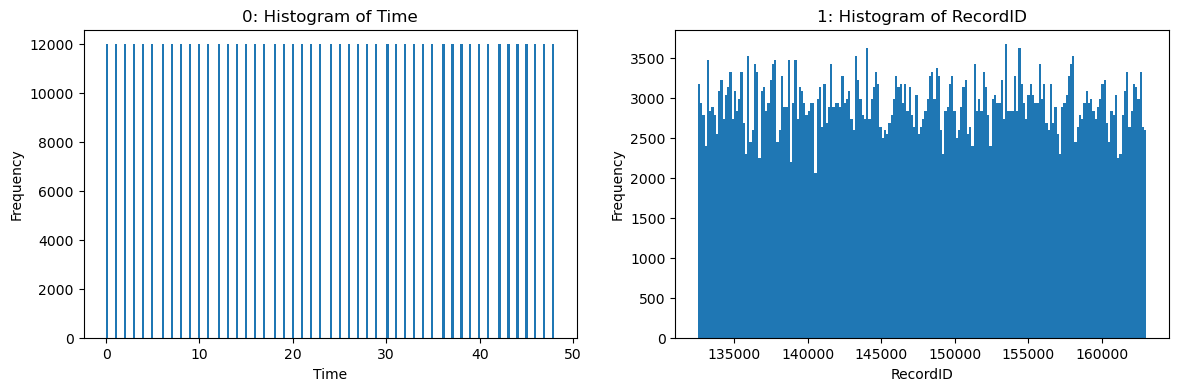

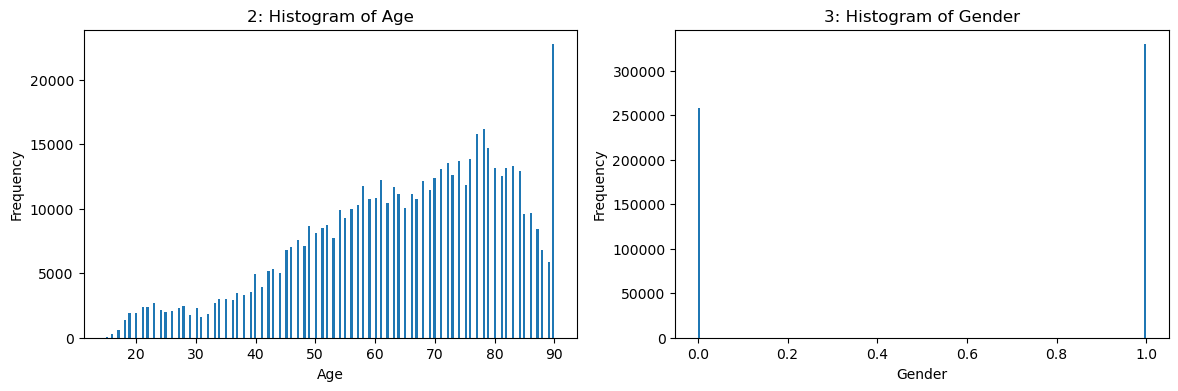

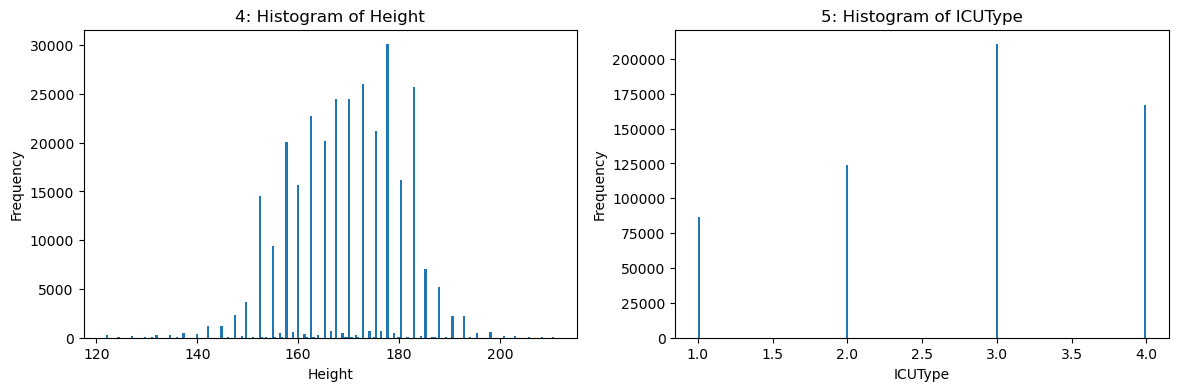

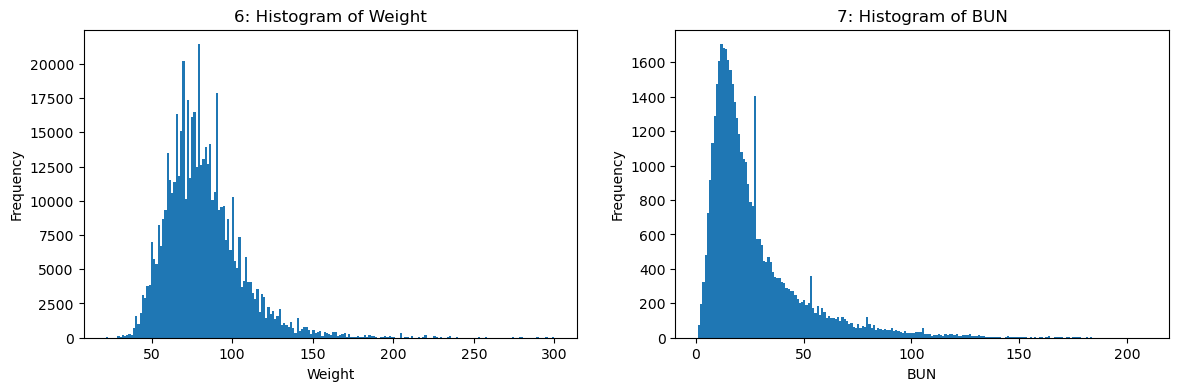

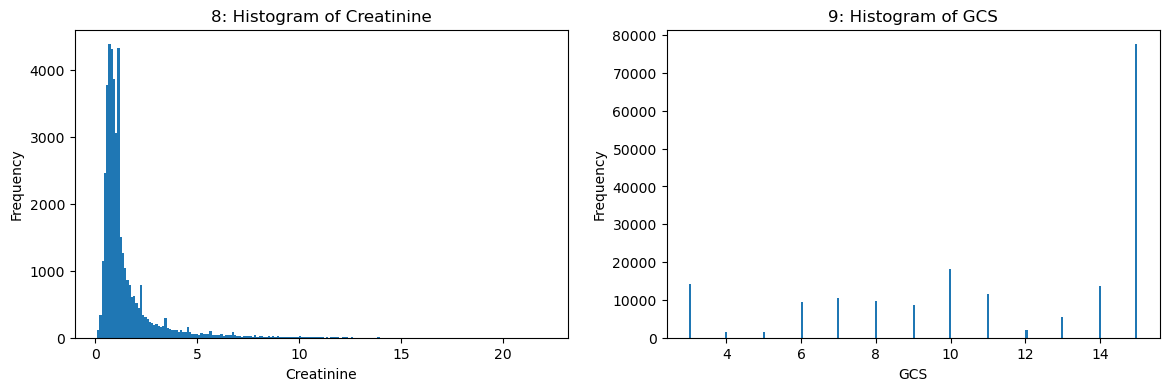

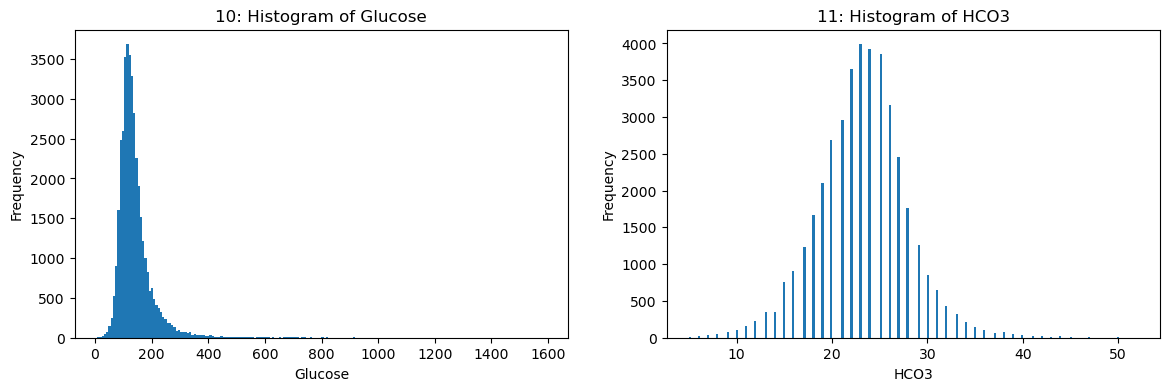

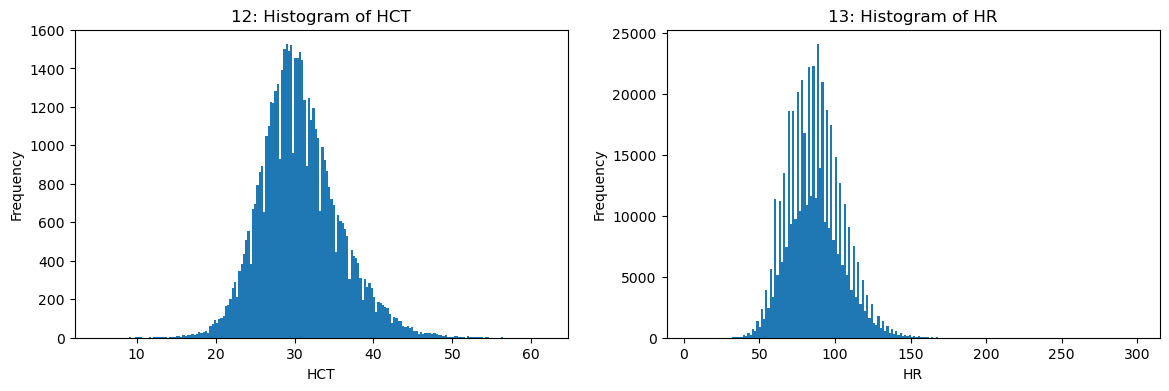

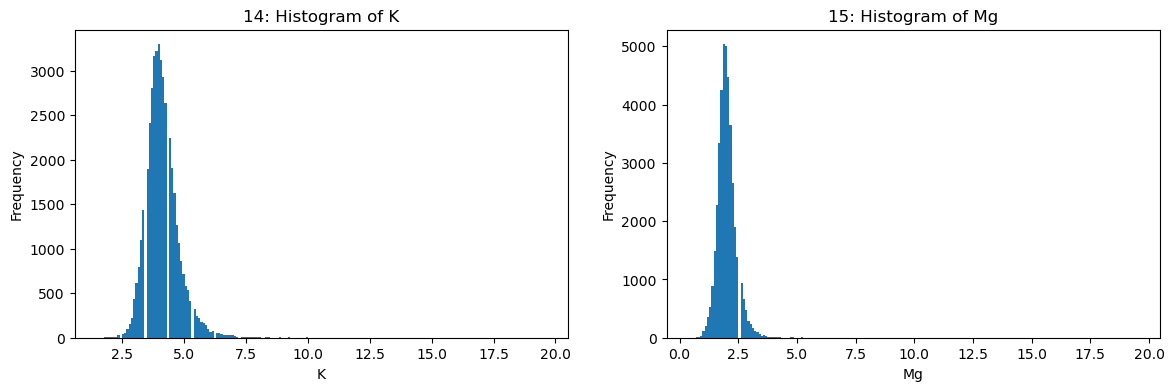

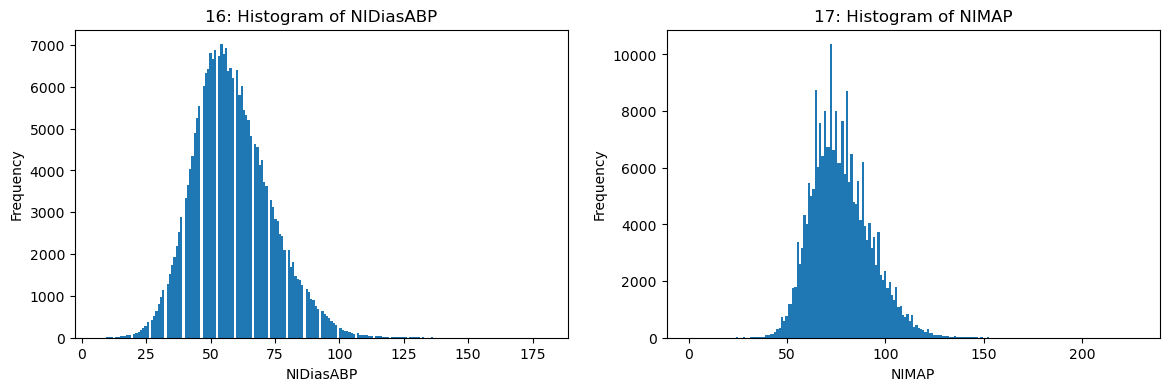

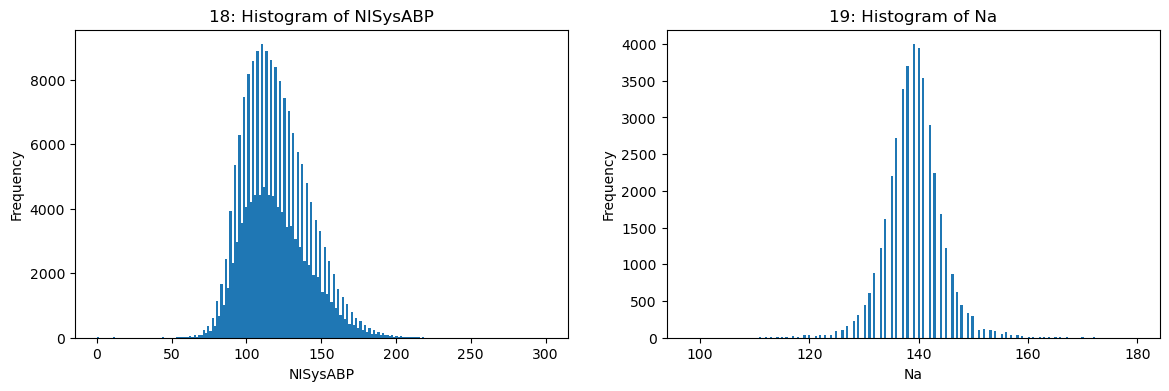

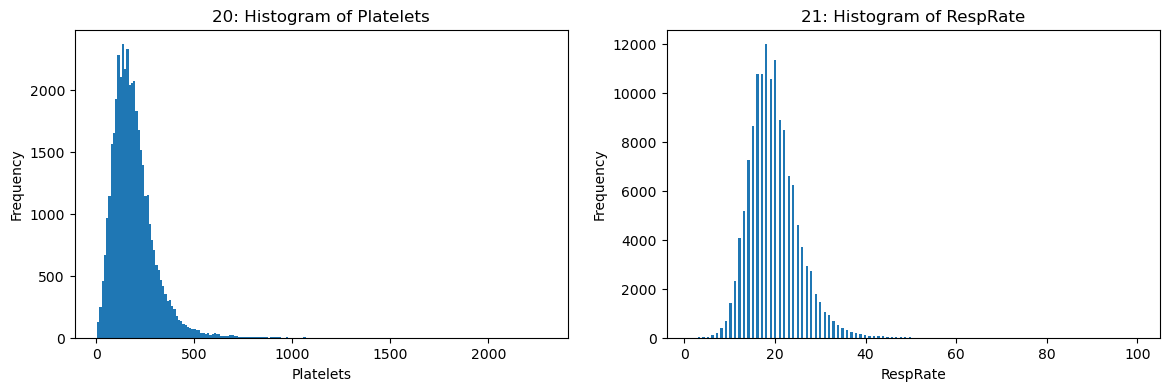

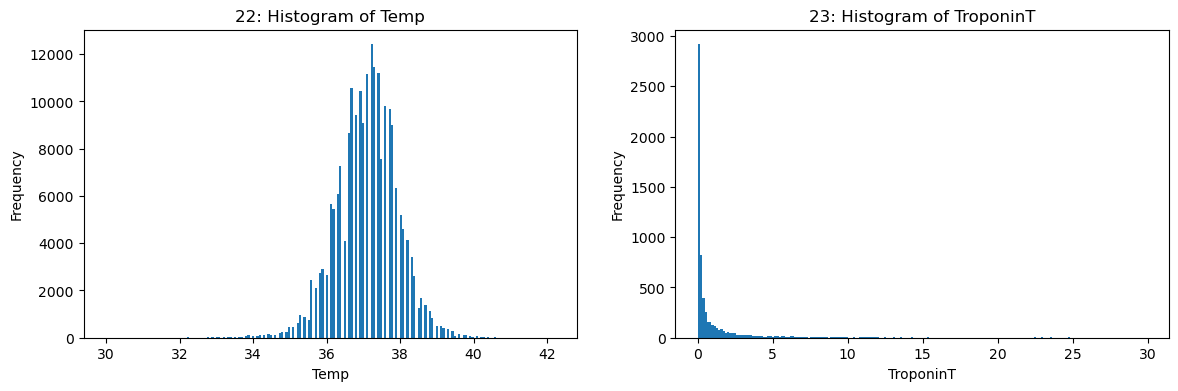

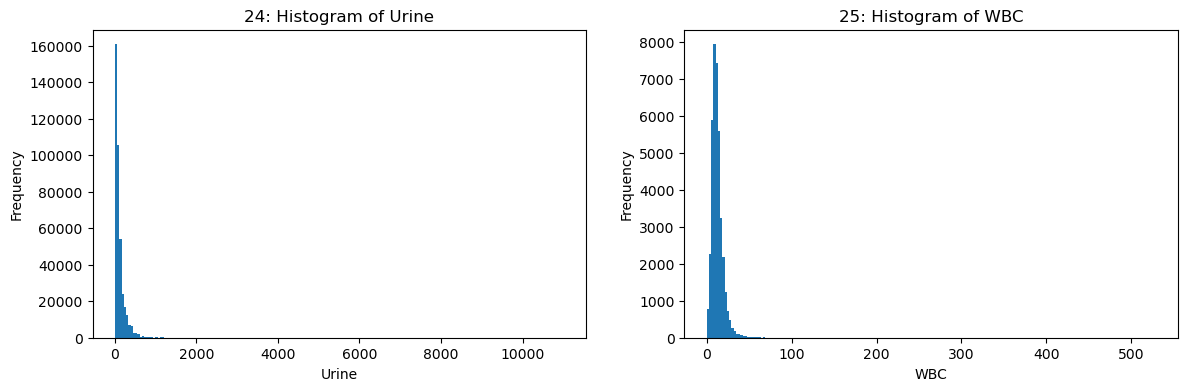

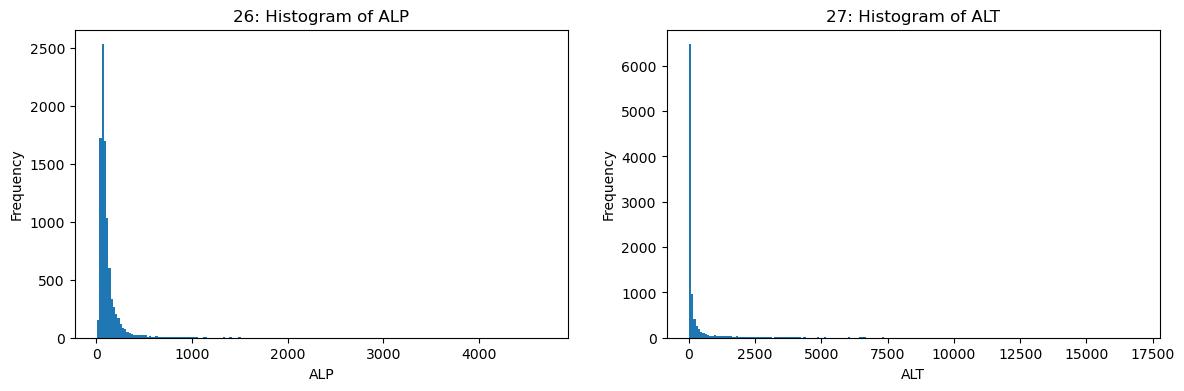

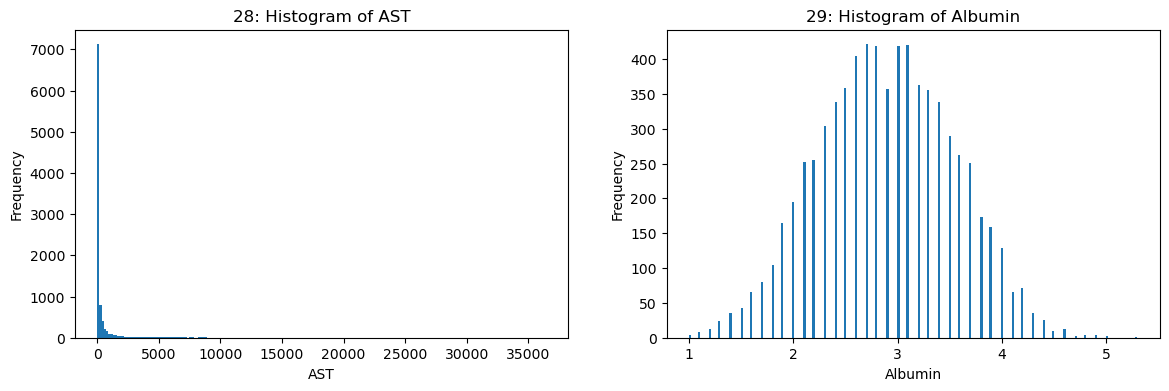

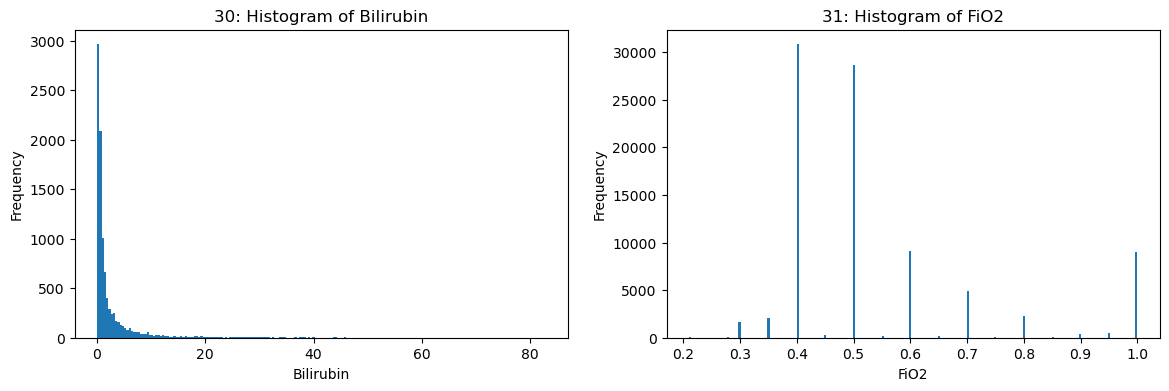

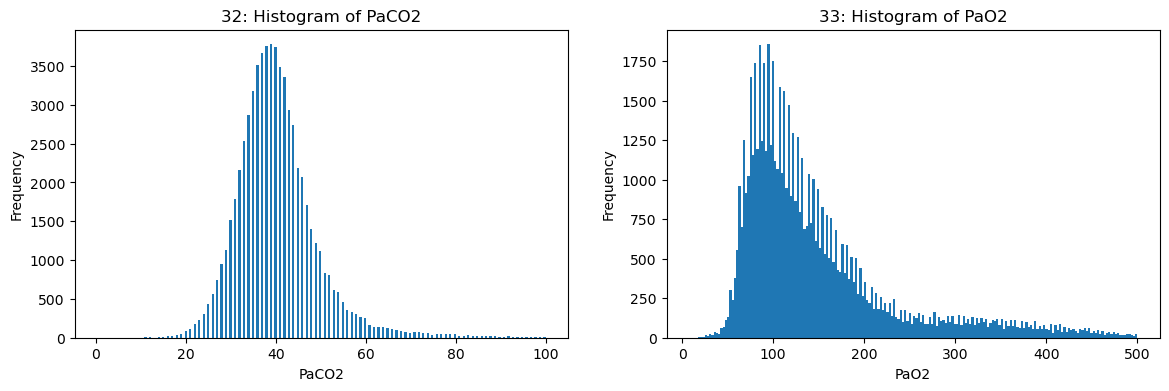

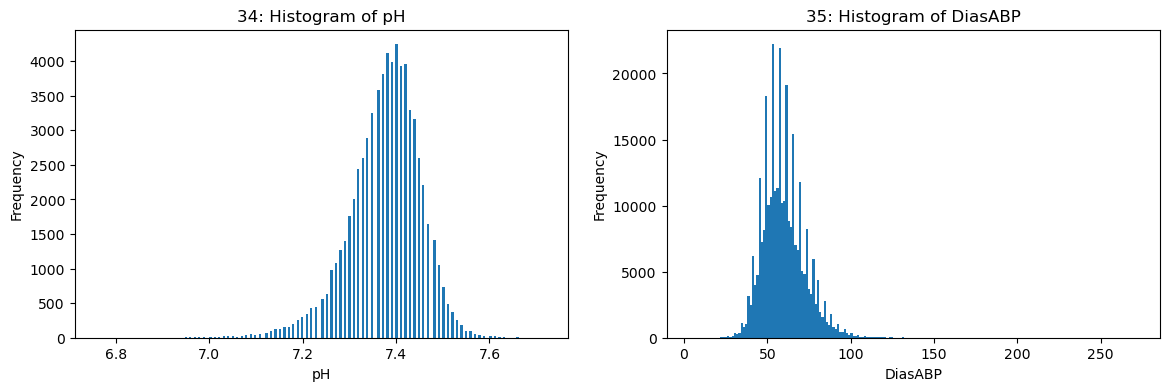

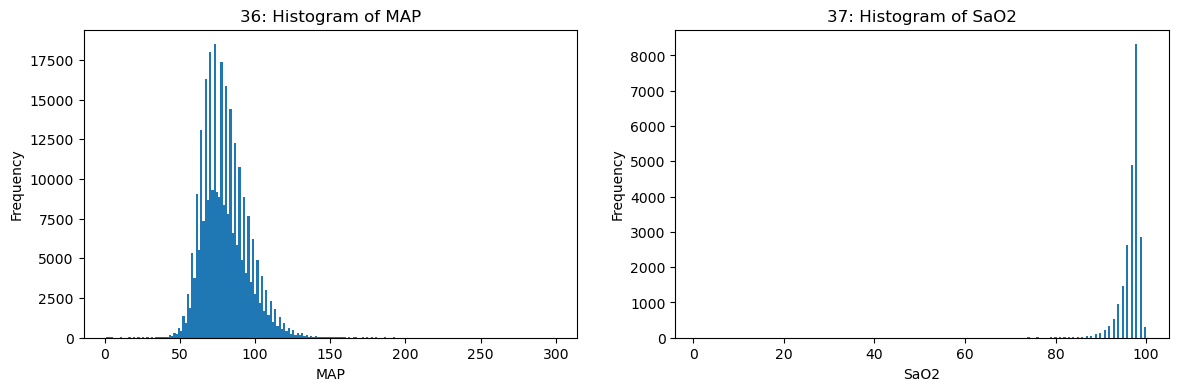

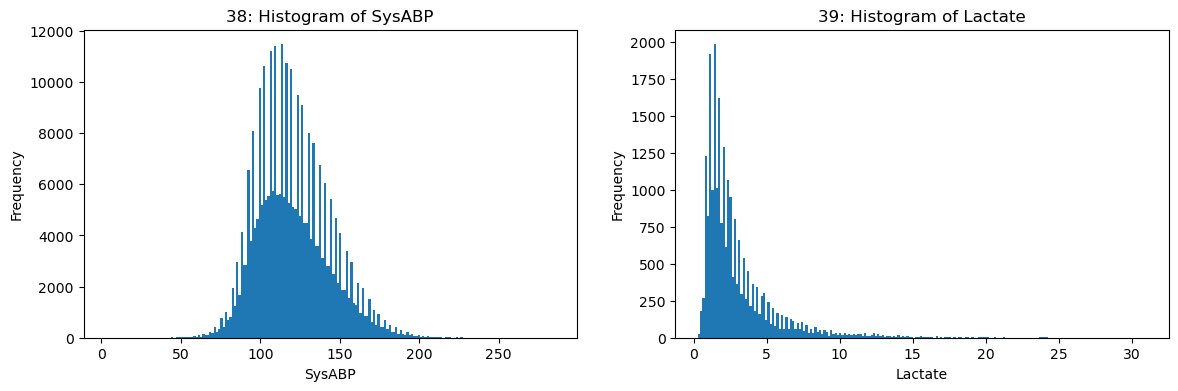

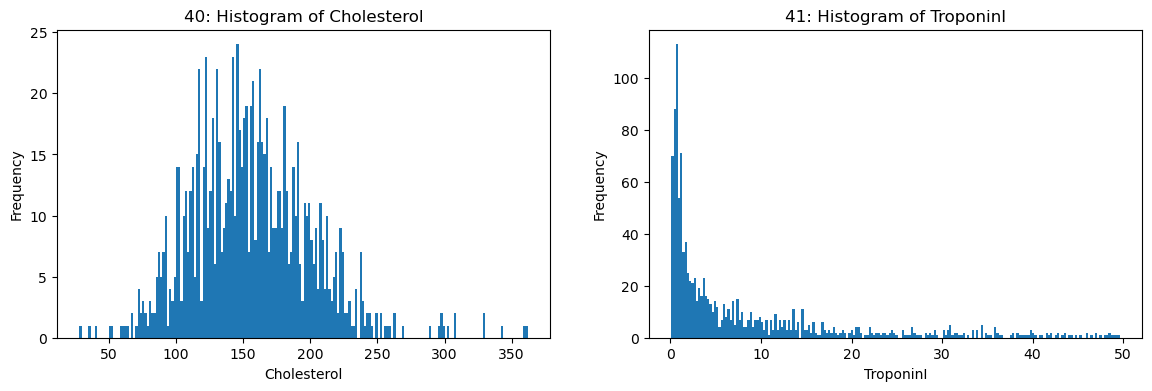

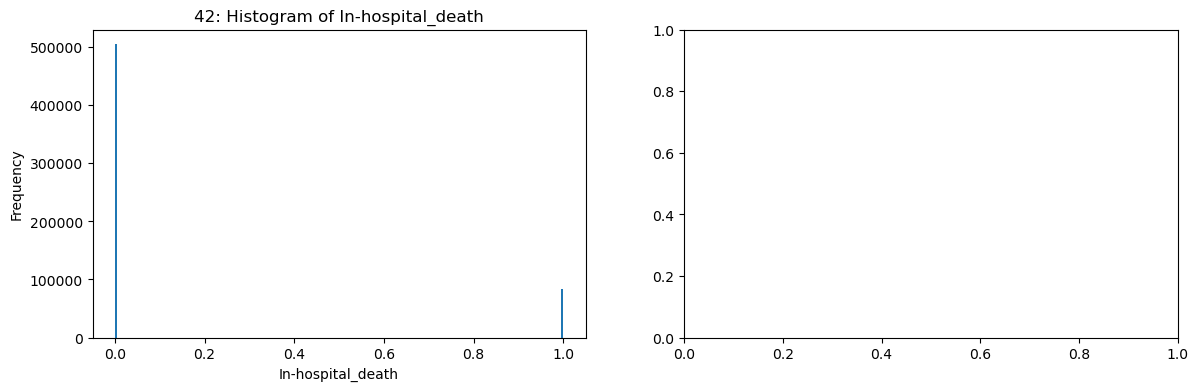

In [87]:
plot_histograms(bins_general, "cleaned")

Data description: 

Continuous 41
Categorical: Gender(43)...

Remove ICU type

In [88]:
vars = list(df.columns)
print(vars)
dem_vars = vars[2:4]
print(dem_vars)
ts_vars = vars[4:42].remove('ICUType')
print(ts_vars)

['Time', 'RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight', 'BUN', 'Creatinine', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR', 'K', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'Platelets', 'RespRate', 'Temp', 'TroponinT', 'Urine', 'WBC', 'ALP', 'ALT', 'AST', 'Albumin', 'Bilirubin', 'FiO2', 'MechVent', 'PaCO2', 'PaO2', 'pH', 'DiasABP', 'MAP', 'SaO2', 'SysABP', 'Lactate', 'Cholesterol', 'TroponinI', 'In-hospital_death']
['Age', 'Gender']
None


#### Plot by categorical variables

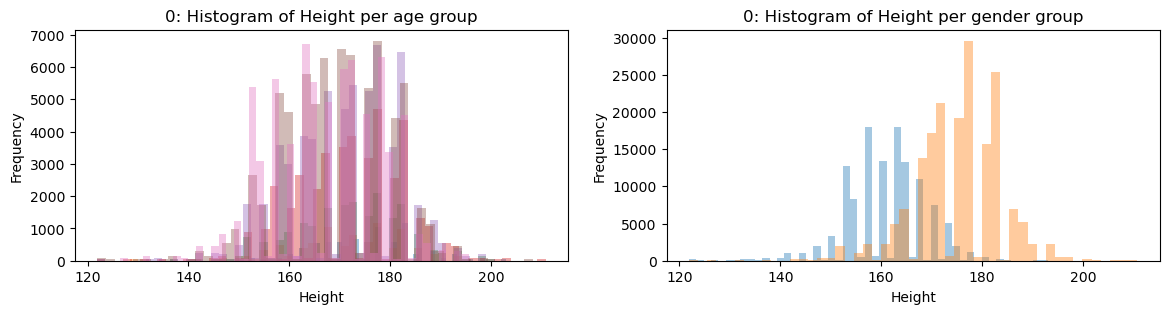

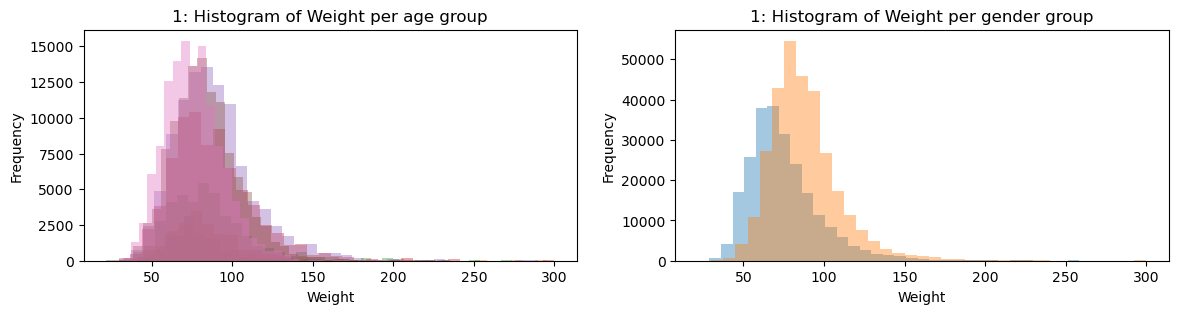

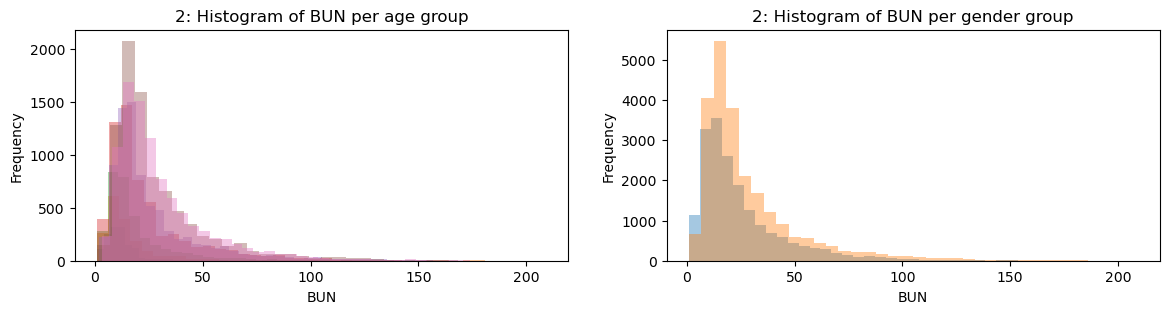

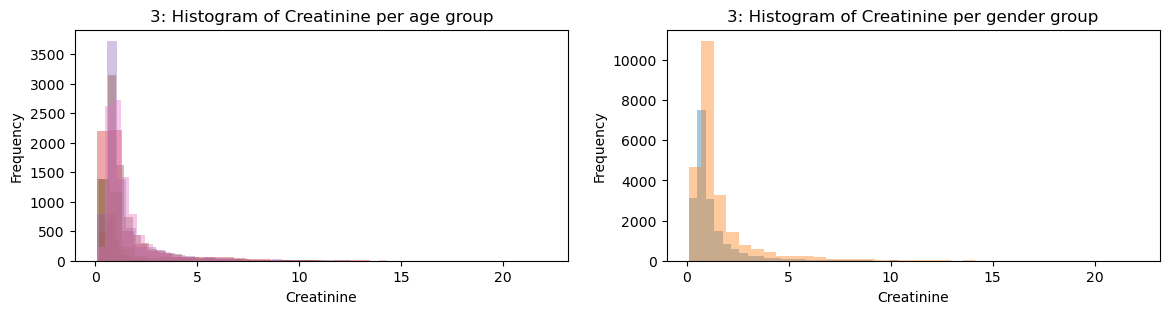

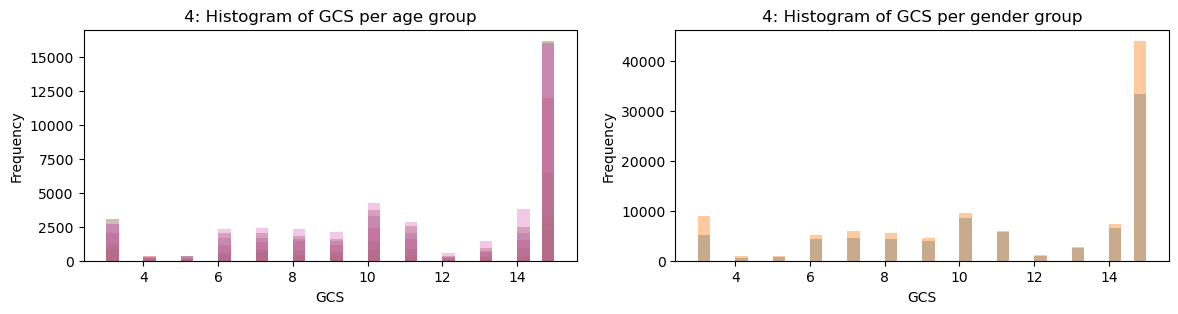

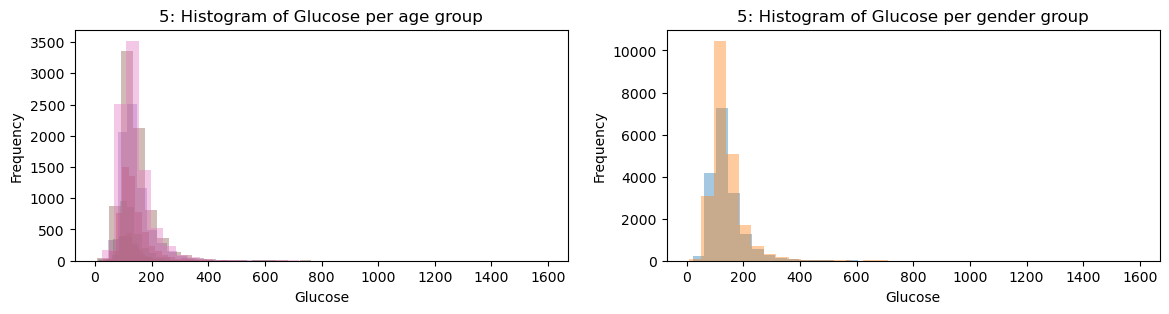

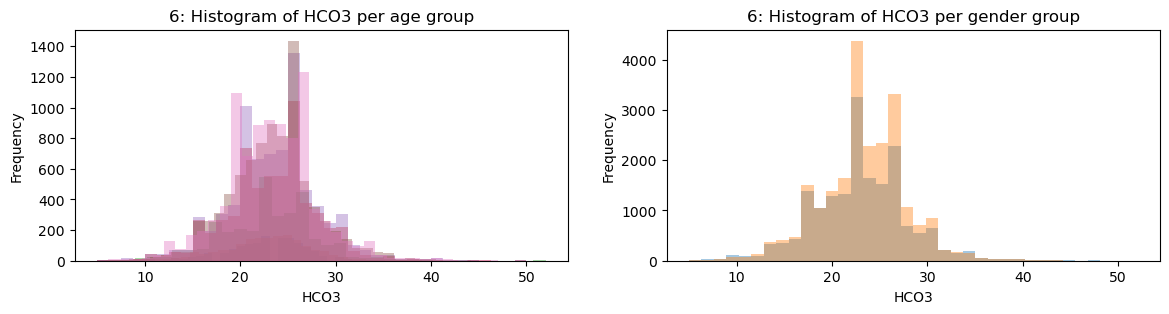

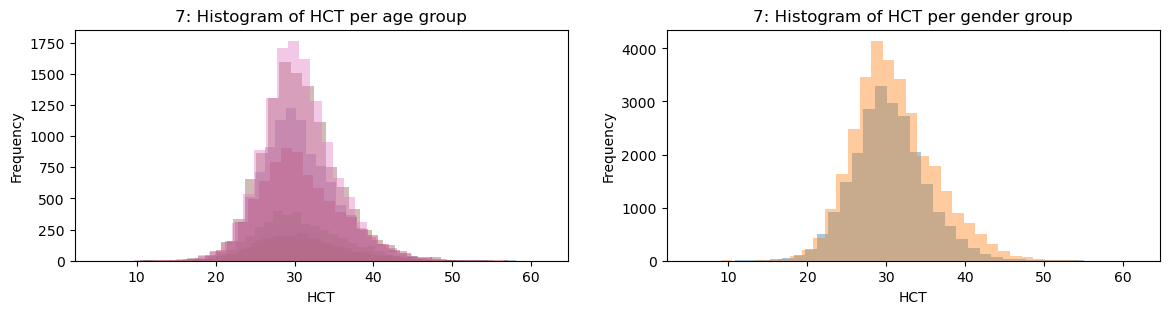

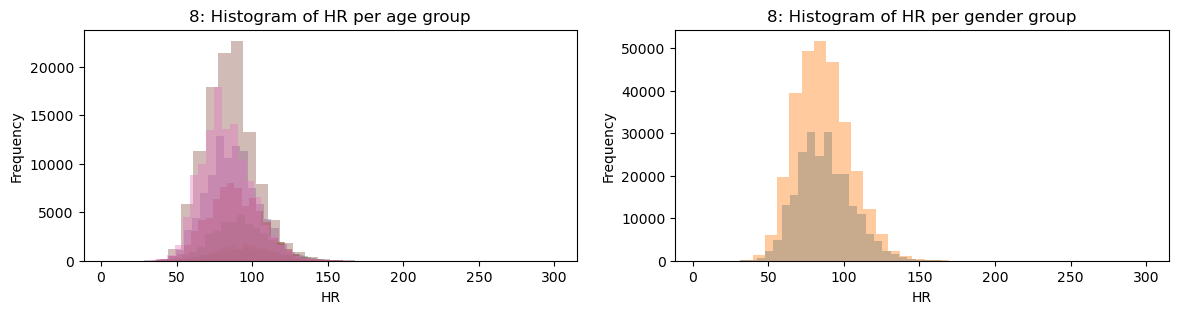

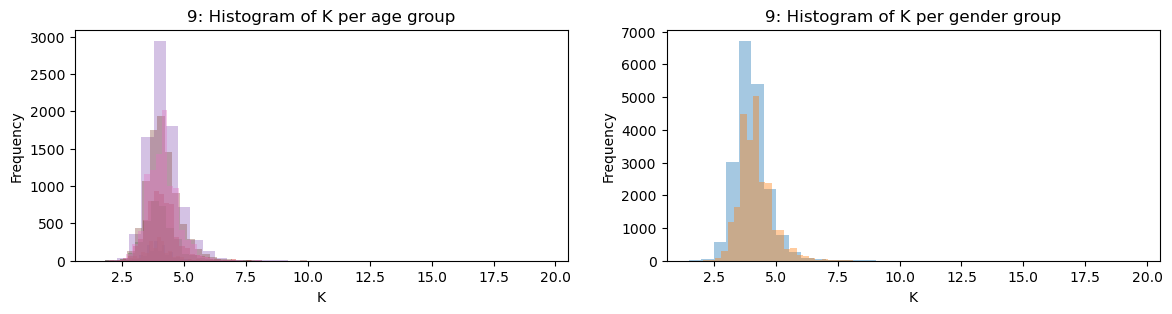

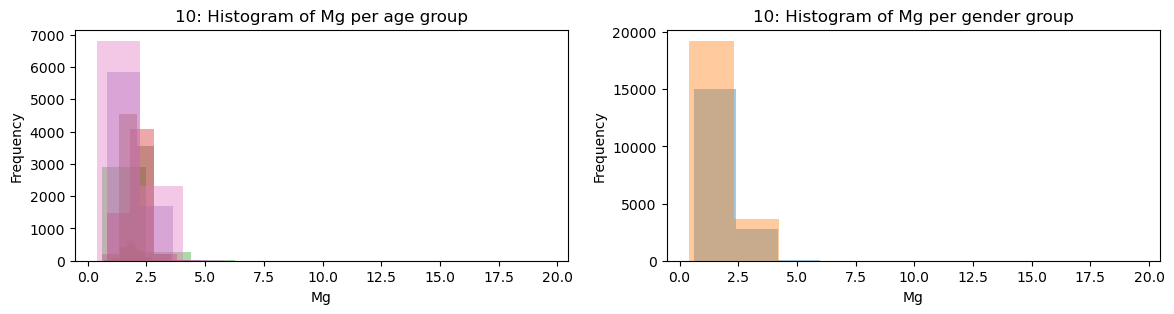

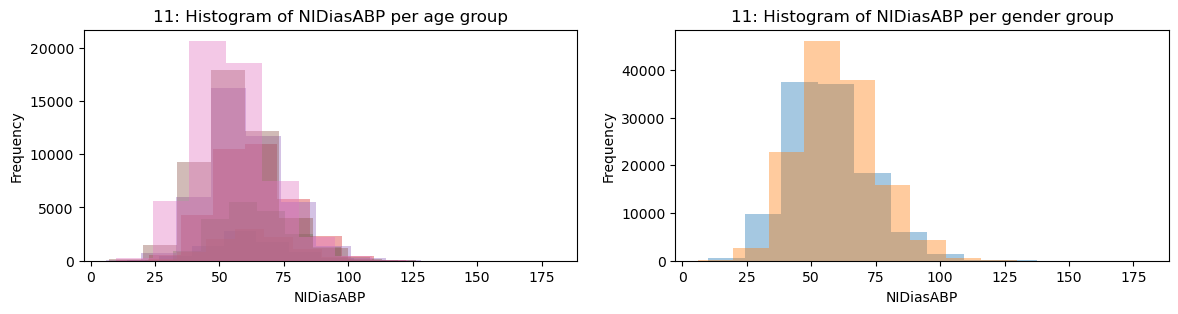

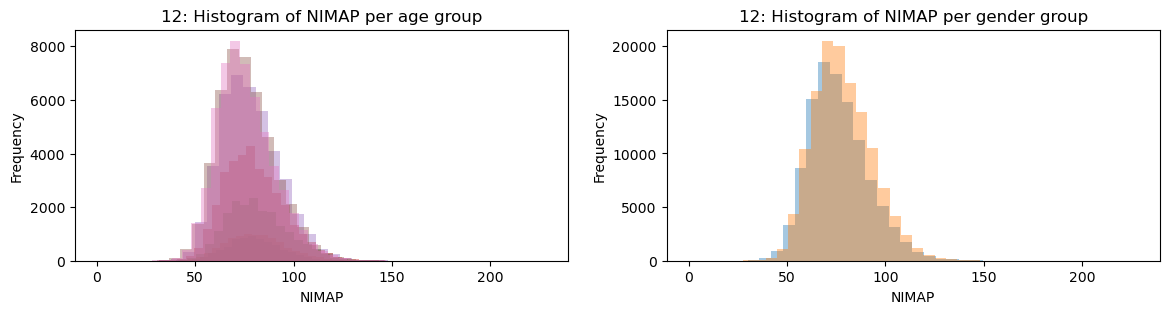

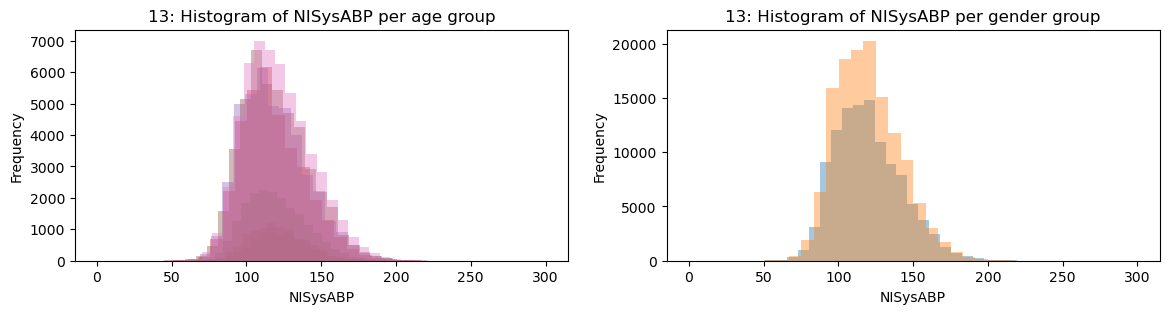

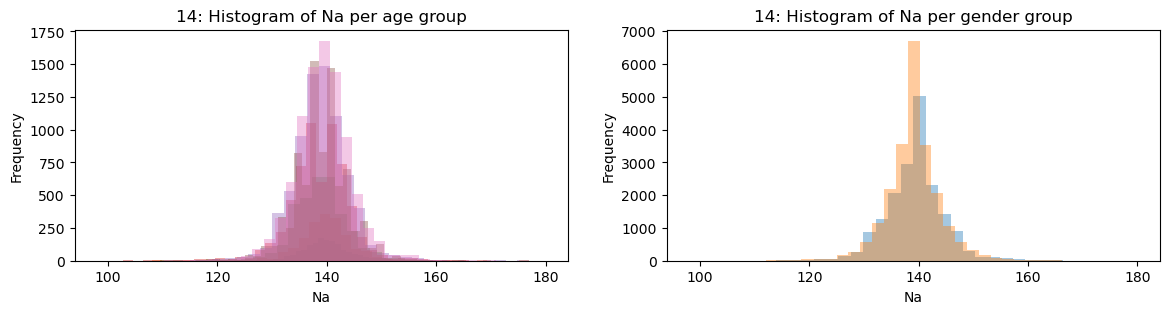

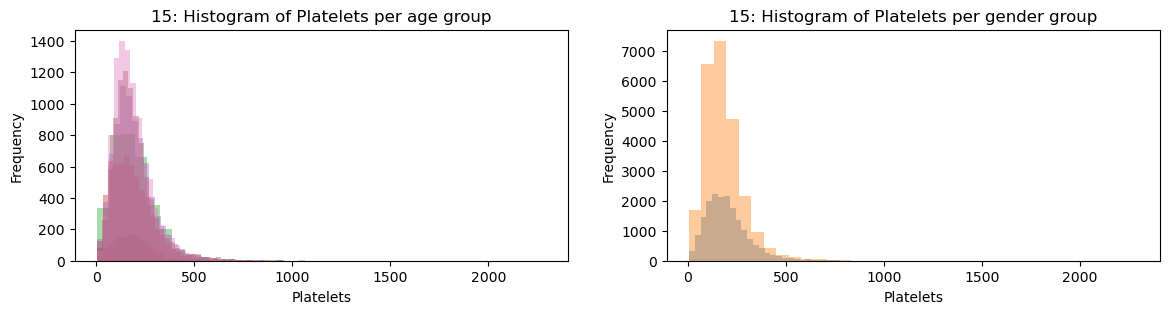

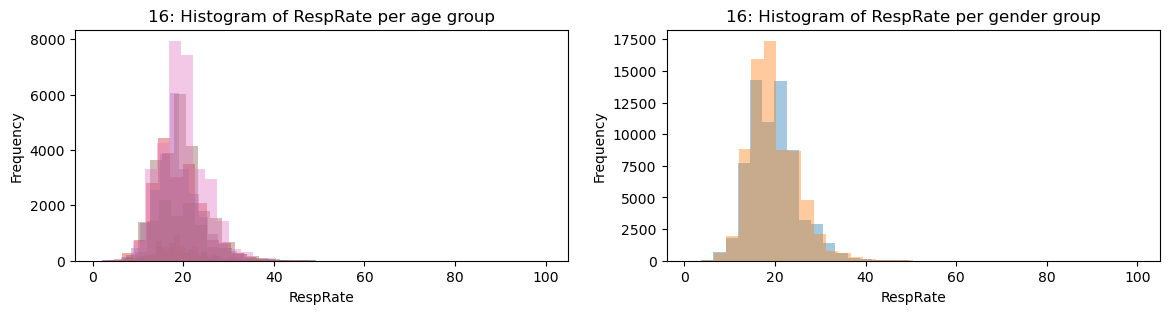

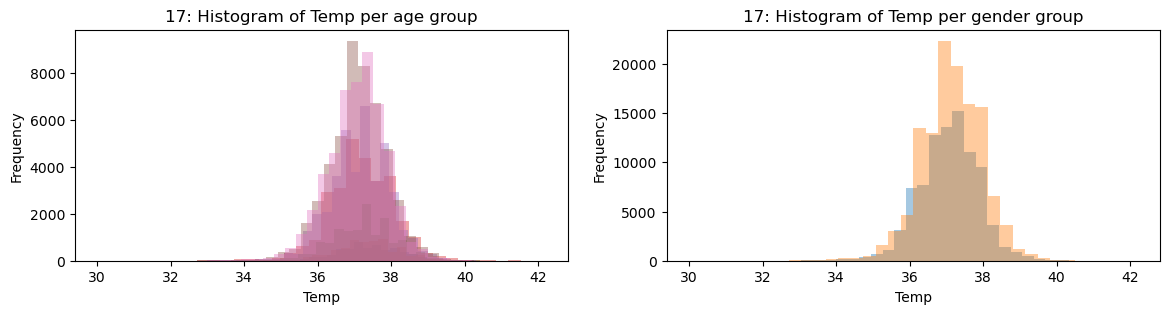

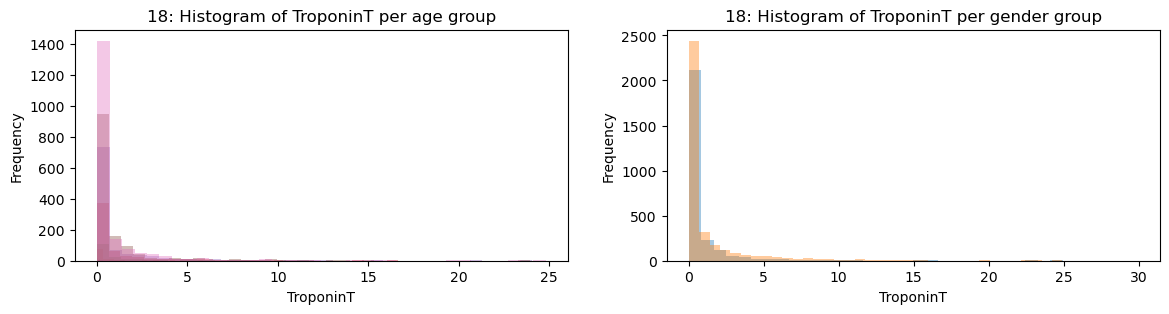

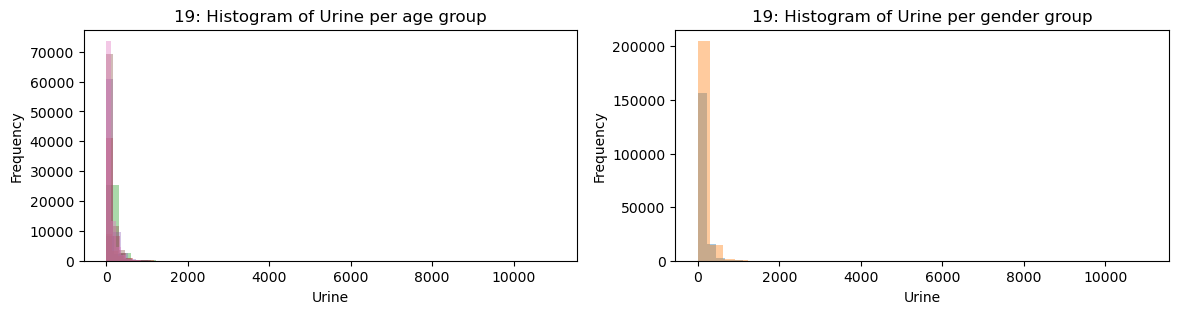

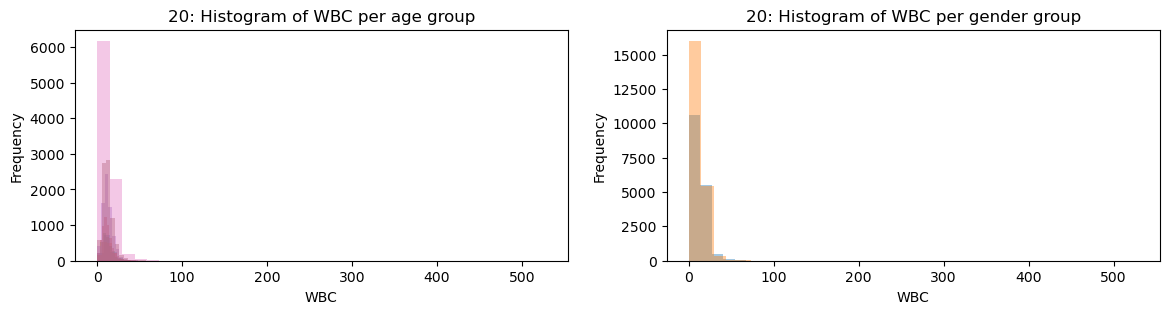

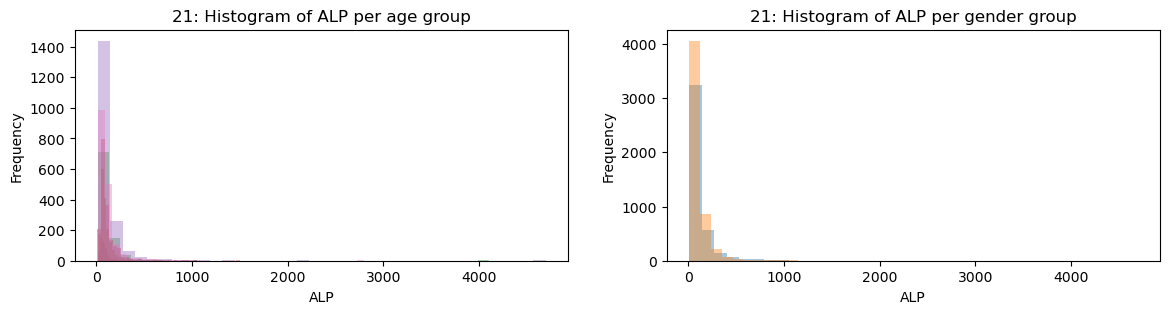

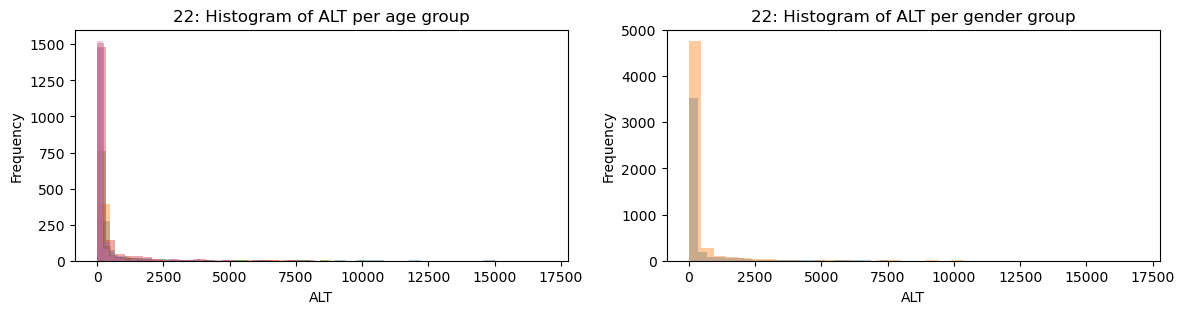

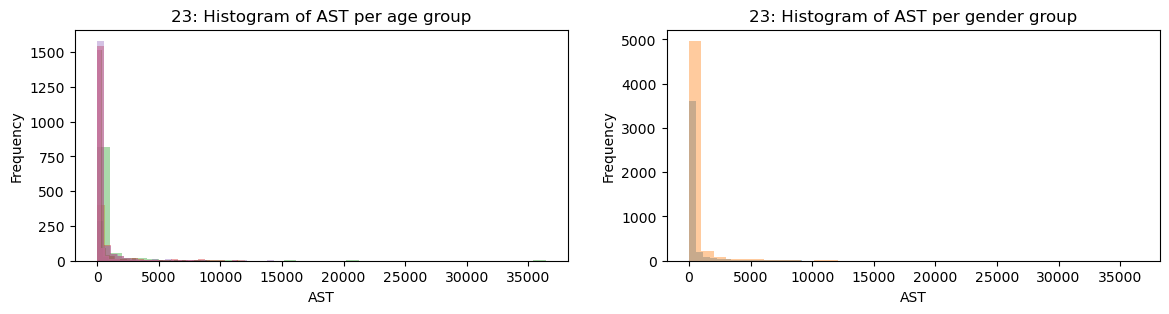

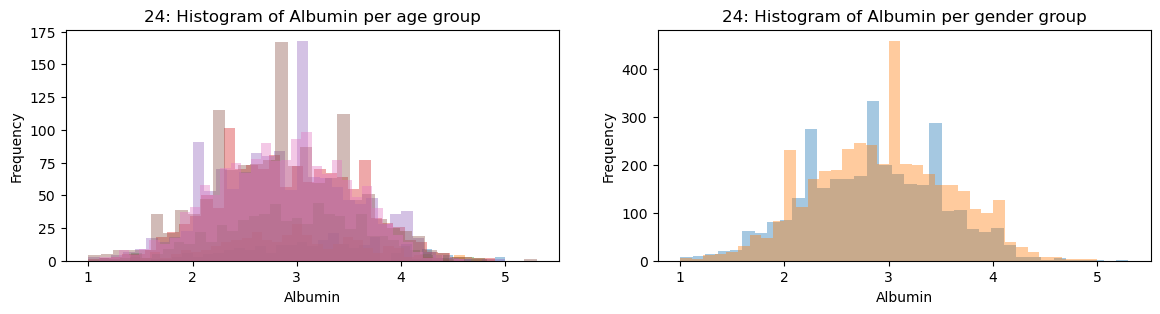

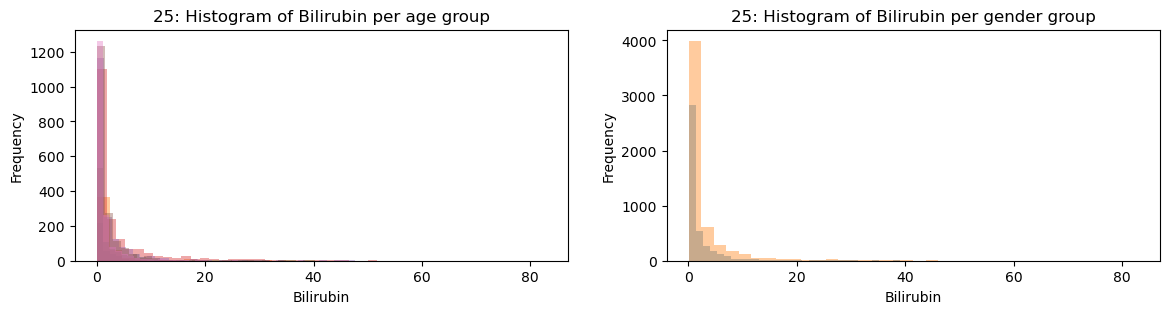

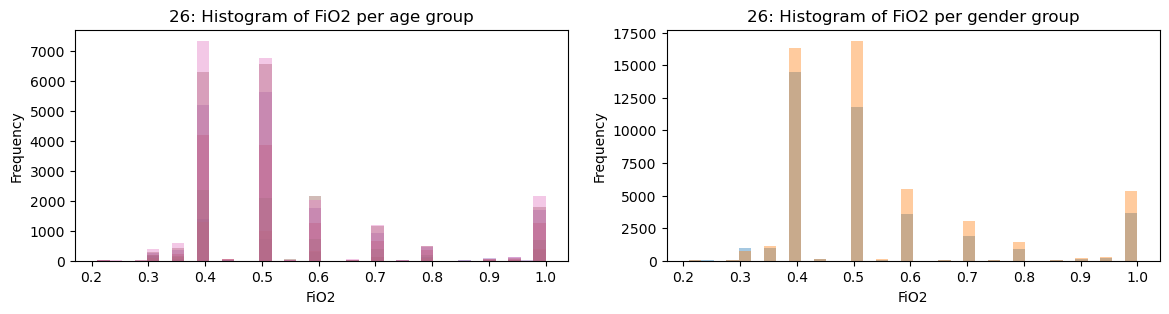

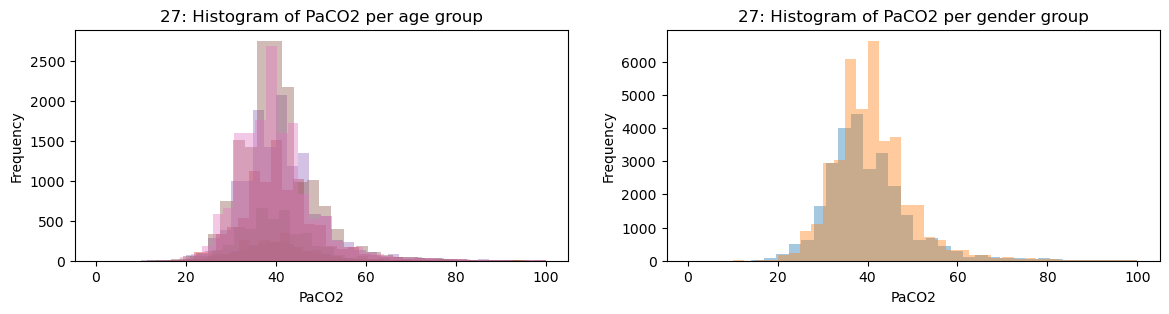

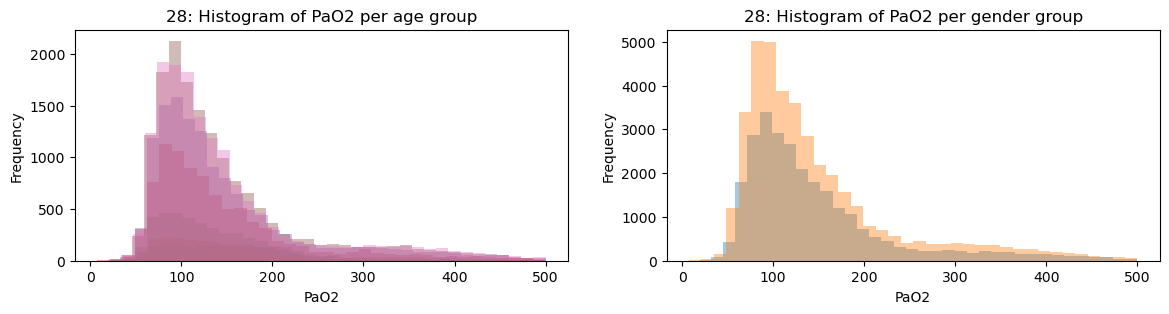

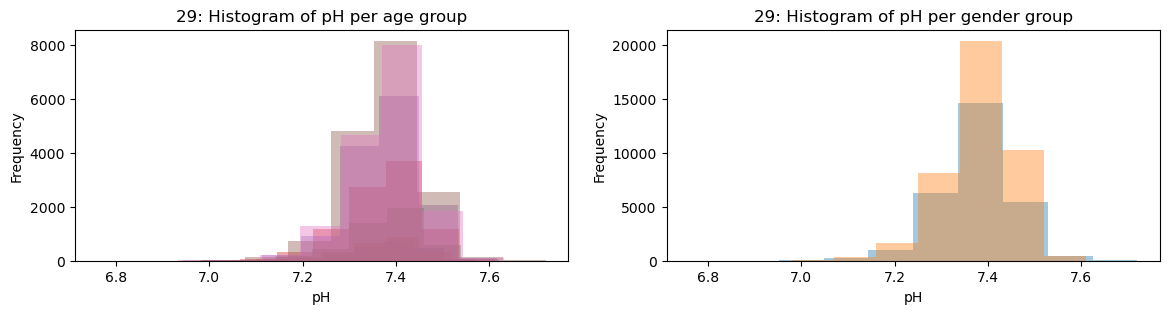

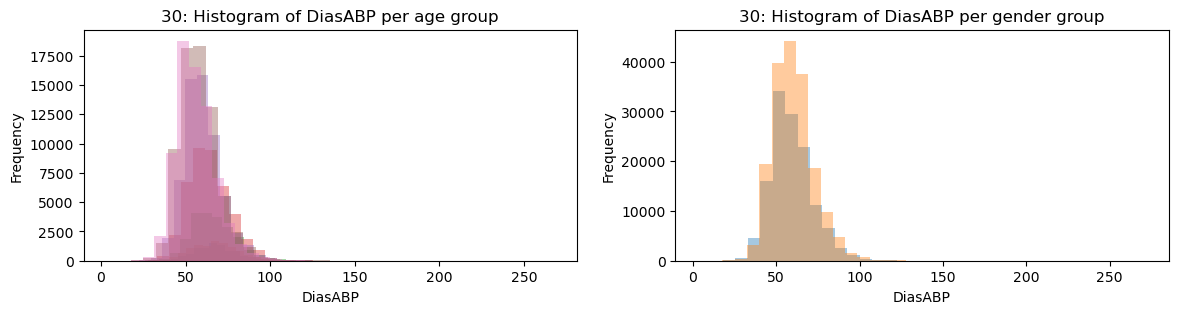

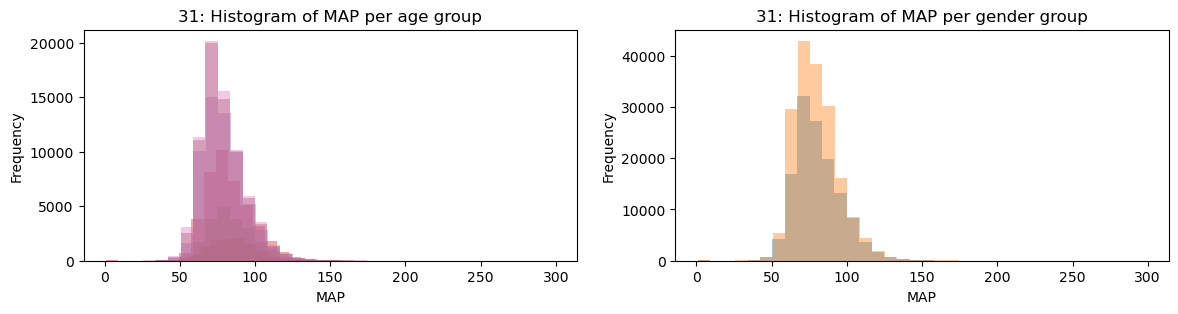

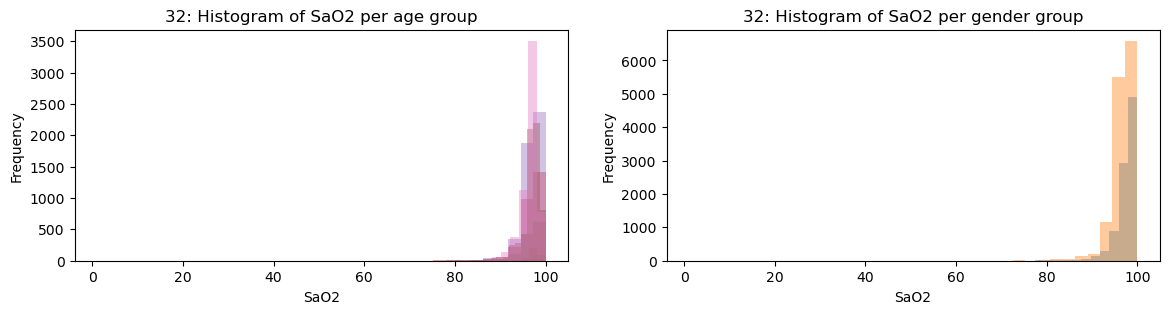

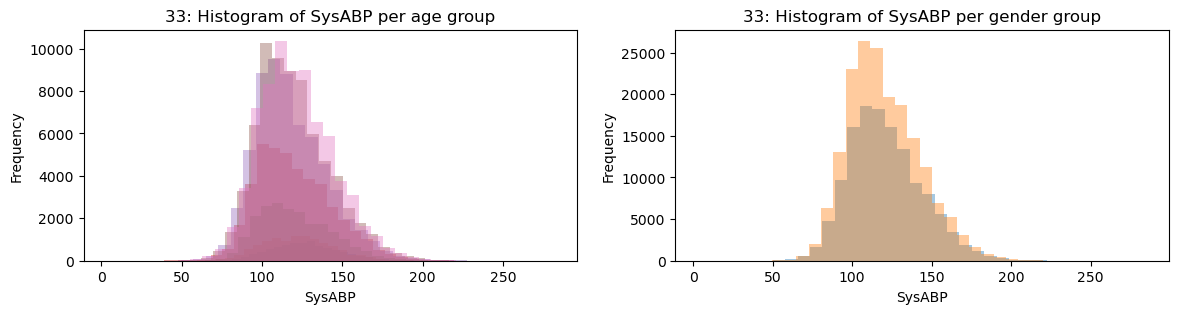

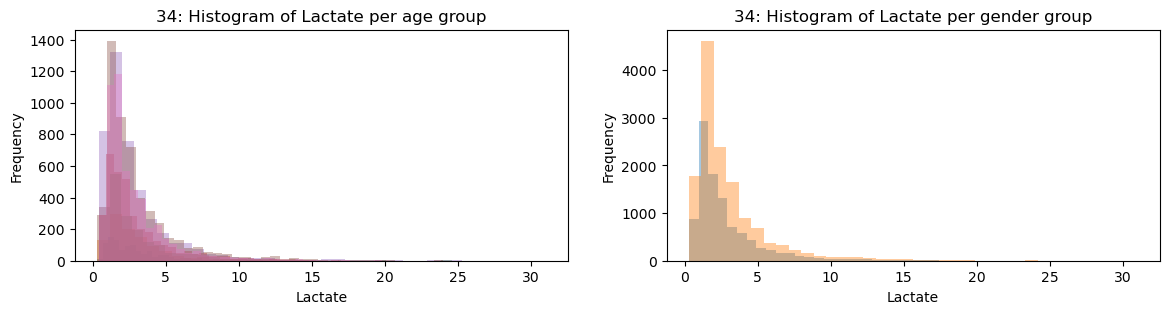

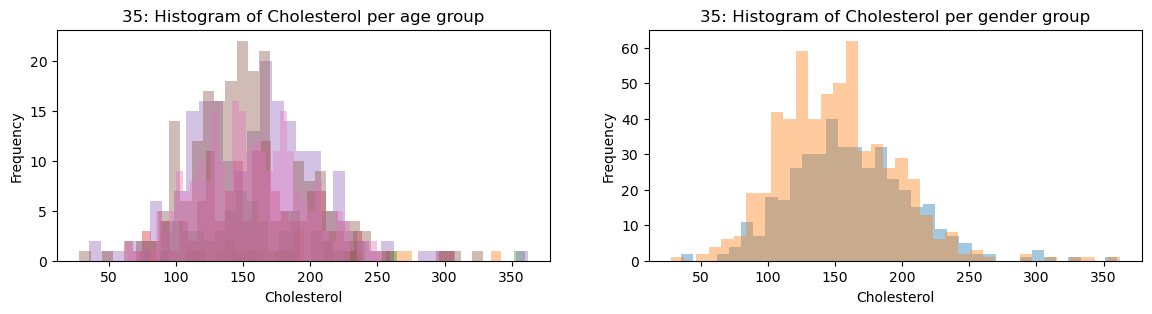

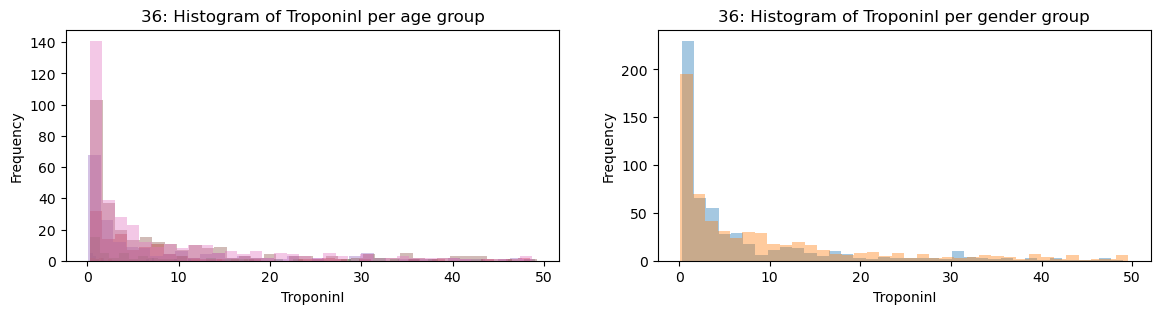

In [89]:
df_all = pd.concat([pd.read_parquet(f"data_{l}_cleaned.parquet") for l in ["a", "b", "c"]], ignore_index=True)

ts_vars = ts_vars = [var for var in list(df_all.columns)[4:42] if var != 'ICUType']
for i, var in enumerate(ts_vars):
    fig, ax = plt.subplots(1, 2, figsize=(14, 3)) # Create a figure and an axes object
    for j in range(0,7):
        binstart = j*10 + 16
        agegroup = df_all.loc[(df_all["Age"] >= binstart) & (df_all["Age"] < binstart + 10), var]
        ax[0].hist(agegroup, alpha=0.4, bins=bins_specific[i])  # Plot the histogram on the axes
    ax[0].set_title(f"{i}: Histogram of {var} per age group")  # Set the title
    ax[0].set_xlabel(var)  # Label the x-axis
    ax[0].set_ylabel("Frequency")  # Label the y-axis

    for j in range(0,2):
        gendergroup = df_all.loc[(df_all["Gender"] == j), var]
        ax[1].hist(gendergroup,alpha=0.4, bins=bins_specific[i])  # Plot the histogram on the axes
    ax[1].set_title(f"{i}: Histogram of {var} per gender group")  # Set the title
    ax[1].set_xlabel(var)  # Label the x-axis
    ax[1].set_ylabel("Frequency")  # Label the y-axis
    plt.show()
    plt.close(fig) # Closes the figure

# Data imputation - Q1.3

### Data Scaling and Transformation

In [90]:
from sklearn.preprocessing import StandardScaler    

# Fit scaler only on 'a'
df_a = pd.read_parquet("data_a_cleaned.parquet")

columns_for_log_transform = ['ALP', 'ALT', 'AST', 'Bilirubin', 'Creatinine', 'Urine', 'TroponinI', 'TroponinT',
                             'WBC', 'Platelets', 'Mg', 'Lactate', 'Glucose', 'BUN', 'DiasABP', 'K', 'PaO2']
df_a[columns_for_log_transform] = np.log(df_a[columns_for_log_transform] + 1e-9)
df_a['SaO2'] = np.log(df_a['SaO2'] / (100 - df_a['SaO2'] + 1e-9))

columns_to_scale = ['Age', 'Height', 'Weight', 'BUN', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3',
                    'HCT', 'HR', 'K', 'Lactate', 'MAP', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'PaCO2', 'PaO2',
                    'Platelets', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'Urine', 'WBC', 'pH', 'TroponinT', 'ALP', 'ALT',
                    'AST', 'Albumin', 'Bilirubin', 'Cholesterol', 'TroponinI']

scaler = StandardScaler()
scaler.fit(df_a[columns_to_scale])

# Apply transform to all
for letter in ["a", "b", "c"]:
    df = pd.read_parquet(f"data_{letter}_cleaned.parquet")

    df[columns_for_log_transform] = np.log(df[columns_for_log_transform] + 1e-9)
    df['SaO2'] = np.log(df['SaO2'] / (100 - df['SaO2'] + 1e-9))

    df[columns_to_scale] = scaler.transform(df[columns_to_scale])

    df.to_parquet(f"data_{letter}_scaled.parquet", engine="pyarrow", index=False)


Display Data

In [91]:
df = pd.read_parquet(f"data_a_scaled.parquet")
print(df.shape)
df.tail(10)

(196000, 43)


,Time,RecordID,Age,Gender,Height,ICUType,Weight,BUN,Creatinine,GCS,Glucose,HCO3,HCT,HR,K,Mg,NIDiasABP,NIMAP,NISysABP,Na,Platelets,RespRate,Temp,TroponinT,Urine,WBC,ALP,ALT,AST,Albumin,Bilirubin,FiO2,PaCO2,PaO2,pH,DiasABP,MAP,SaO2,SysABP,Lactate,Cholesterol,TroponinI,In-hospital_death
195990,39,141565.0,-0.469709,1.0,1.217246,1.0,0.73161,NaN,NaN,NaN,NaN,NaN,NaN,0.858715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.220915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.946452,0.480249,NaN,0.351221,NaN,NaN,NaN,0
195991,40,141565.0,-0.469709,1.0,1.217246,1.0,0.73161,NaN,NaN,NaN,NaN,NaN,NaN,0.577575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.220915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.083009,0.727150,NaN,0.752209,NaN,NaN,NaN,0
195992,41,141565.0,-0.469709,1.0,1.217246,1.0,0.73161,NaN,NaN,0.905372,NaN,NaN,NaN,0.465118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.075019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.215875,0.912325,NaN,1.108643,NaN,NaN,NaN,0
195993,42,141565.0,-0.469709,1.0,1.217246,1.0,0.73161,-1.15738,-1.514259,NaN,-0.561656,1.249104,0.741233,0.408890,-0.129833,-0.508081,NaN,NaN,NaN,-1.556468,1.452568,NaN,NaN,NaN,0.022946,0.251739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.946452,0.541974,NaN,0.573992,NaN,NaN,NaN,0
195994,43,141565.0,-0.469709,1.0,1.217246,1.0,0.73161,NaN,NaN,NaN,NaN,NaN,NaN,0.746259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.408674,1.159226,NaN,1.064089,NaN,NaN,NaN,0
195995,44,141565.0,-0.469709,1.0,1.217246,1.0,0.73161,NaN,NaN,NaN,NaN,NaN,NaN,0.465118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.594195,1.406126,NaN,1.331414,NaN,NaN,NaN,0
195996,45,141565.0,-0.469709,1.0,1.217246,1.0,0.73161,NaN,NaN,0.905372,NaN,NaN,NaN,0.408890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.337238,NaN,0.317015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.772969,1.529577,NaN,1.375968,NaN,NaN,NaN,0
195997,46,141565.0,-0.469709,1.0,1.217246,1.0,0.73161,NaN,NaN,NaN,NaN,NaN,NaN,0.858715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.831144,1.159226,NaN,1.465077,NaN,NaN,NaN,0
195998,47,141565.0,-0.469709,1.0,1.217246,1.0,0.73161,NaN,NaN,NaN,NaN,NaN,NaN,0.690031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.157183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.876725,0.480249,NaN,0.484884,NaN,NaN,NaN,0
195999,48,141565.0,-0.469709,1.0,1.217246,1.0,0.73161,NaN,NaN,NaN,NaN,NaN,NaN,0.521347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.215875,0.850600,NaN,0.618547,NaN,NaN,NaN,0


Todo: Weird spikes above normal distribution, e.g. NISysABP, likely come from data imputation (adding repeated values). Maybe isnt ideal. 

### Imputation

In [103]:
## Forward fill TODO: maybe later different imputation and fill values that never come up (mean value)

def impute_missing_values(df):
    #This fills forward and then backward per RecordID, handling missing values at the start too.
    df_filled = df.groupby('RecordID').ffill().bfill()
    #then fills remaining all-NaN columns with the overall mean.
    return df.combine_first(df_filled).fillna(df.mean(numeric_only=True))

In [104]:
for letter in ["a", "b", "c"]:
    df = pd.read_parquet(f"data_{letter}_scaled.parquet")
    
    df = impute_missing_values(df)

    df.to_parquet(f"data_{letter}_scaled.parquet", engine="pyarrow", index=False)   

In [105]:
df = pd.read_parquet(f"data_a_scaled.parquet")
df.head(50)

,ALP,ALT,AST,Age,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,DiasABP,FiO2,GCS,Gender,Glucose,HCO3,HCT,HR,Height,ICUType,In-hospital_death,K,Lactate,MAP,Mg,NIDiasABP,NIMAP,NISysABP,Na,PaCO2,PaO2,Platelets,RecordID,RespRate,SaO2,SysABP,Temp,Time,TroponinI,TroponinT,Urine,WBC,Weight,pH
0,-1.051062,-0.4137,-1.041956,-1.665694,-0.341317,1.627492,-0.287861,-0.815687,1.053339,-0.584485,2.465471,0.905372,0.0,4.182595,-2.574523,-1.037699,1.420996,1.68676,3.0,0,1.664938,-0.17151,-0.445628,1.745415,-1.014629,-0.570817,0.029915,0.179207,0.39743,-0.537616,0.964105,132592.0,0.426204,0.02034,-1.074514,-0.608415,0,0.714232,-0.300136,0.272988,0.561820,-0.451334,0.190483
1,-1.051062,-0.4137,-1.041956,-1.665694,-0.341317,1.627492,-0.287861,-0.815687,1.053339,-0.584485,2.465471,0.905372,0.0,4.182595,-2.574523,-1.037699,1.420996,1.68676,3.0,0,1.664938,-0.17151,-0.445628,1.745415,-1.014629,-0.570817,0.029915,0.179207,0.39743,-0.537616,0.964105,132592.0,0.426204,0.02034,-1.074514,-0.608415,1,0.714232,-0.300136,0.272988,0.561820,-0.451334,0.190483
2,-1.051062,-0.4137,-1.041956,-1.665694,-0.341317,1.627492,-0.287861,-0.815687,1.053339,-0.584485,2.465471,0.905372,0.0,4.182595,-2.574523,-1.037699,1.420996,1.68676,3.0,0,1.664938,-0.17151,-0.445628,1.745415,-1.014629,-0.570817,0.029915,0.179207,0.39743,-0.537616,0.964105,132592.0,0.426204,0.02034,-1.074514,-0.608415,2,0.714232,-0.300136,0.272988,0.561820,-0.451334,0.190483
3,-1.051062,-0.4137,-1.041956,-1.665694,-0.341317,1.627492,-0.287861,-0.815687,1.053339,-0.584485,2.465471,0.905372,0.0,4.182595,-2.574523,-1.037699,1.477224,1.68676,3.0,0,1.664938,-0.17151,-0.445628,1.745415,-0.346486,-0.030079,0.216447,0.179207,0.39743,-0.537616,0.964105,132592.0,0.243589,0.02034,-1.074514,-0.608415,3,0.714232,-0.300136,0.272988,0.561820,-0.451334,0.190483
4,-1.051062,-0.4137,-1.041956,-1.665694,-0.341317,1.627492,-0.287861,-0.815687,1.053339,-0.584485,2.465471,0.905372,0.0,4.182595,-2.574523,-1.037699,1.420996,1.68676,3.0,0,1.664938,-0.17151,-0.445628,1.745415,-0.680558,-0.391022,-0.063351,0.179207,0.39743,-0.537616,0.964105,132592.0,0.791436,0.02034,-1.074514,-0.608415,4,0.714232,-0.300136,0.075019,0.561820,-0.451334,0.190483
5,-1.051062,-0.4137,-1.041956,-1.665694,-0.341317,1.627492,-0.287861,-0.815687,1.053339,-0.584485,2.465471,0.905372,0.0,4.182595,-2.574523,-1.037699,1.477224,1.68676,3.0,0,1.664938,-0.17151,-0.445628,1.745415,0.054399,0.284901,0.309713,0.179207,0.39743,-0.537616,0.964105,132592.0,-1.034722,0.02034,-1.074514,-0.608415,5,0.714232,-0.300136,0.075019,0.561820,-0.451334,0.190483
6,-1.051062,-0.4137,-1.041956,-1.665694,-0.341317,1.477893,-0.287861,-0.815687,0.848187,-0.584485,2.465471,0.905372,0.0,2.782514,-1.724828,-1.397483,1.589680,1.68676,3.0,0,0.761530,-0.17151,-0.445628,0.515407,0.321656,0.487678,0.356346,0.950618,0.39743,-0.537616,0.964105,132592.0,1.156668,0.02034,-1.074514,-0.017382,6,0.714232,-0.300136,0.157183,0.561820,-0.451334,0.190483
7,-1.051062,-0.4137,-1.041956,-1.665694,-0.341317,1.477893,-0.287861,-0.815687,0.848187,-0.584485,2.465471,0.905372,0.0,2.782514,-1.724828,-1.397483,1.364768,1.68676,3.0,0,0.761530,-0.17151,-0.445628,0.515407,0.054399,0.443067,0.636145,0.950618,0.39743,-0.537616,0.964105,132592.0,0.608820,0.02034,-1.074514,-0.017382,7,0.714232,-0.300136,0.119045,0.561820,-0.451334,0.190483
8,-1.051062,-0.4137,-1.041956,-1.665694,-0.341317,1.431986,-0.287861,-0.815687,0.772895,-0.584485,2.465471,0.905372,0.0,1.810363,-1.724828,-1.497423,1.027399,1.68676,3.0,0,0.331408,-0.17151,-0.445628,0.278139,-0.680558,-0.616104,-0.529682,1.143470,0.39743,-0.537616,0.964105,132592.0,-1.034722,0.02034,-1.074514,-0.017382,8,0.714232,-0.300136,0.022946,0.561820,-0.451334,0.190483
9,-1.051062,-0.4137,-1.041956,-1.665694,-0.341317,1.431986,-0.287861,-0.815687,0.772895,-0.584485,2.465471,0.905372,0.0,1.810363,-1.724828,-1.497423,1.027399,1.68676,3.0,0,0.331408,-0.17151,-0.445628,0.278139,-0.346486,-0.368040,-0.483049,1.143470,0.39743,-0.537616,0.964105,132592.0,-0.486875,0.02034,-1.074514,-0.

### Display imputed/scaled/transformed data

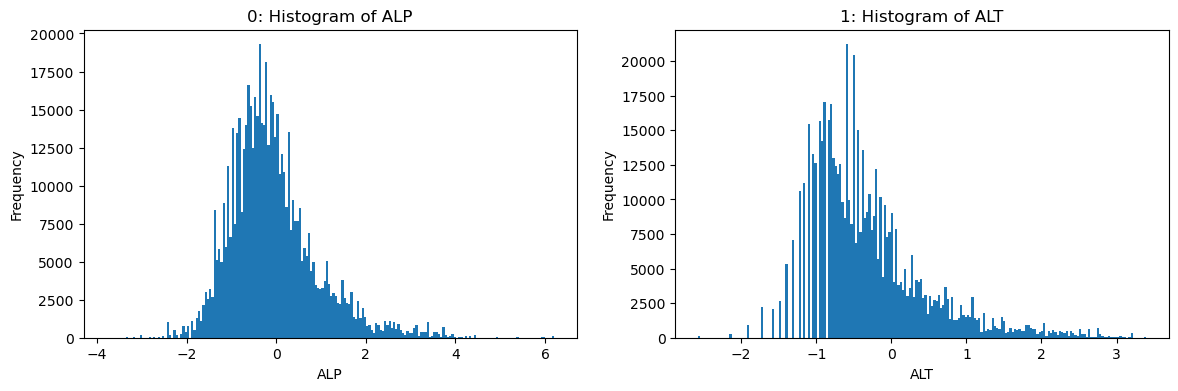

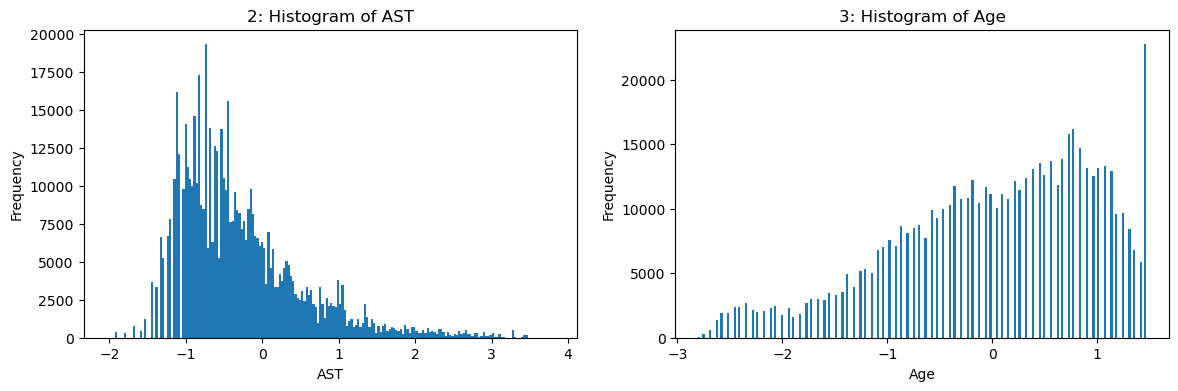

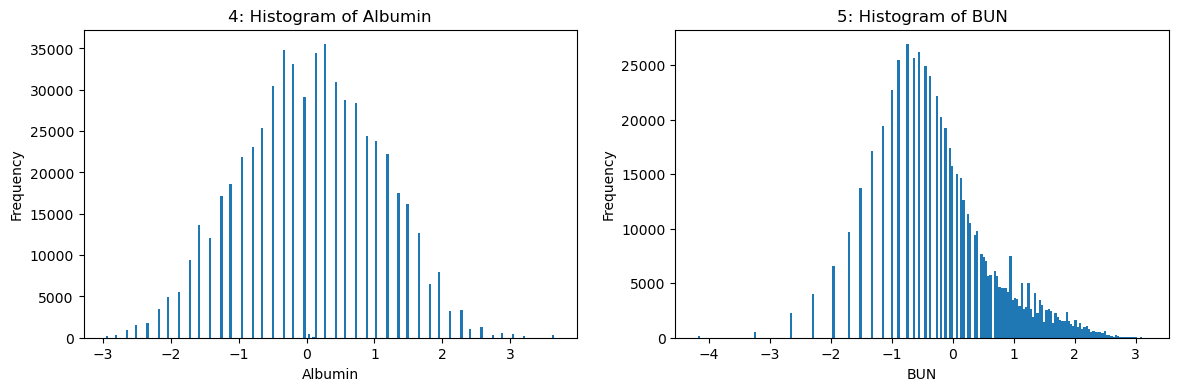

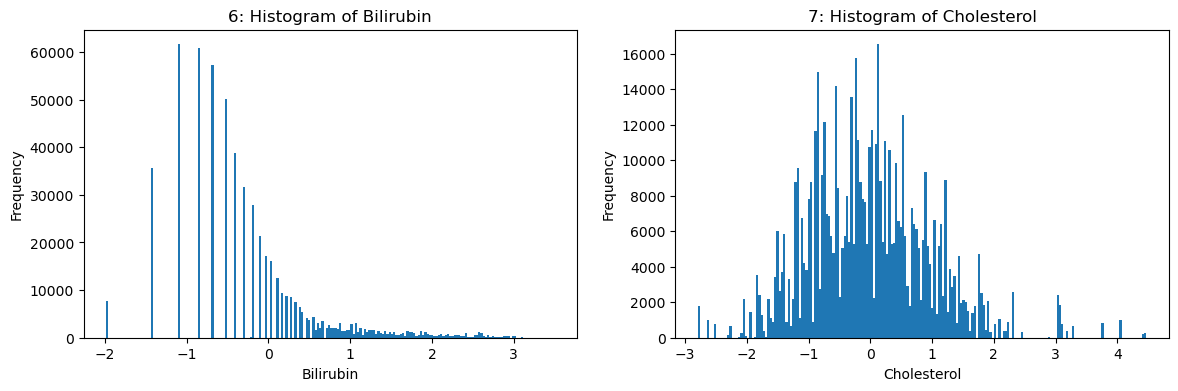

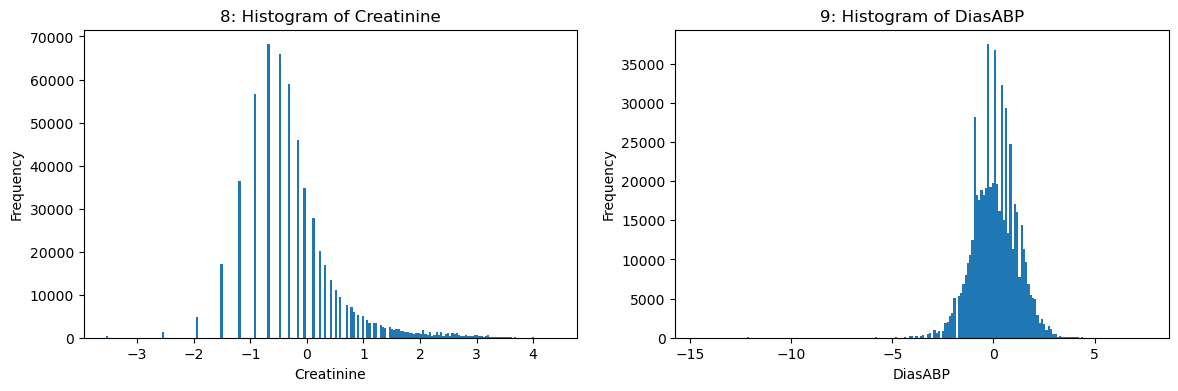

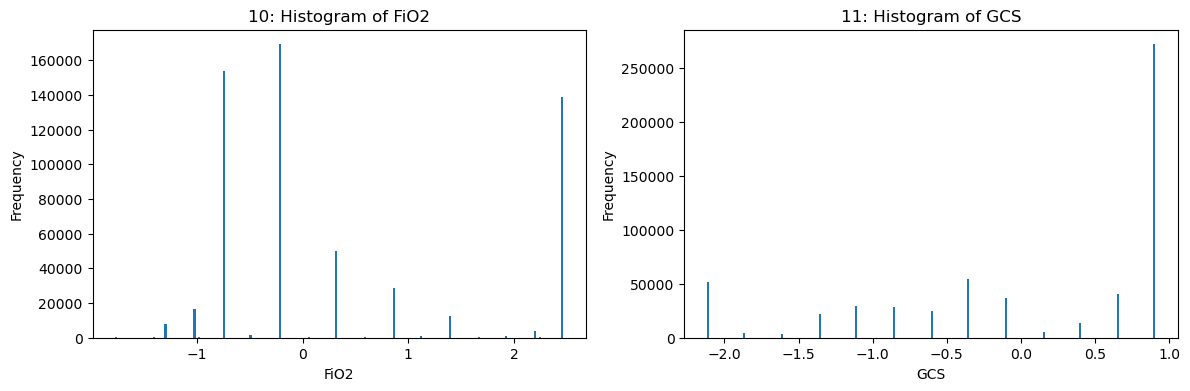

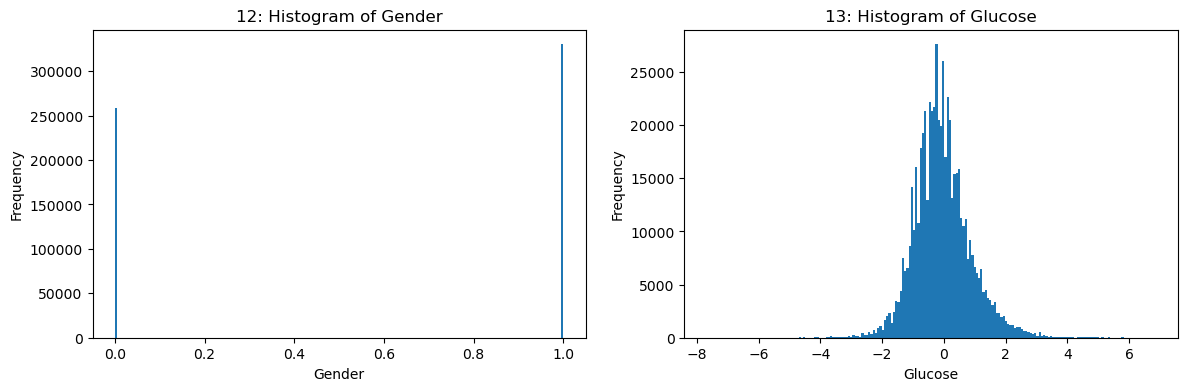

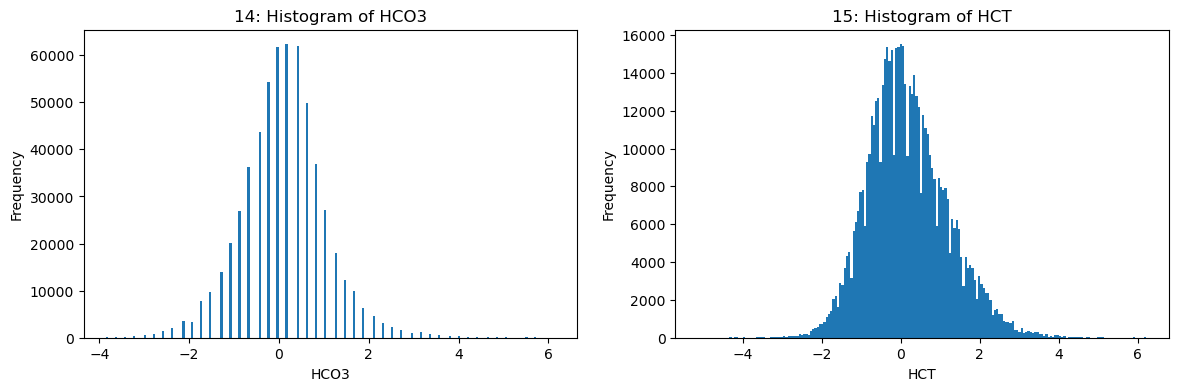

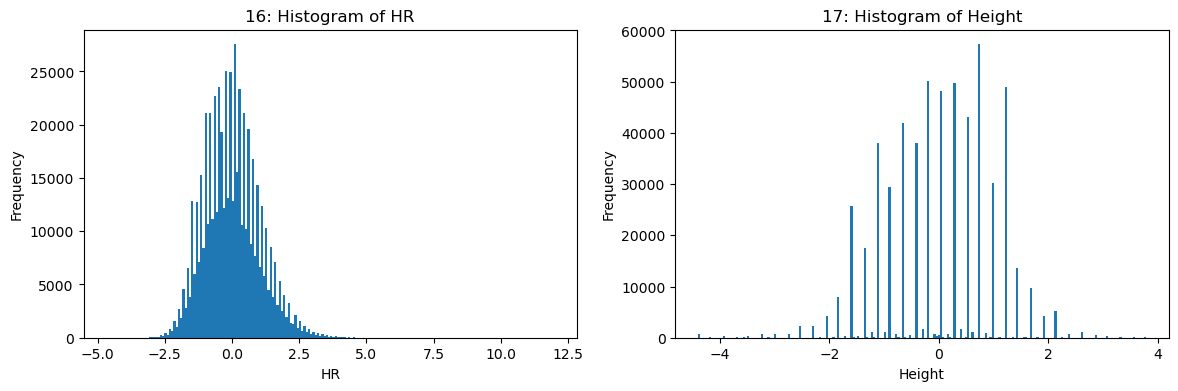

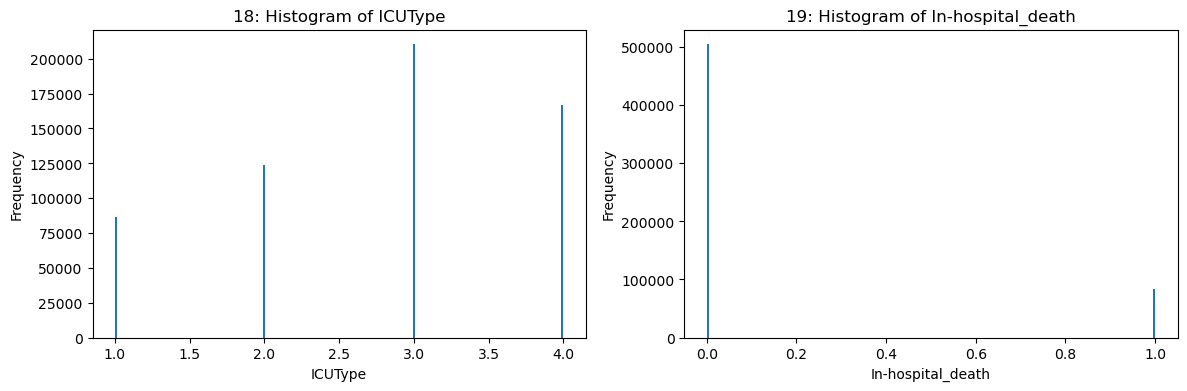

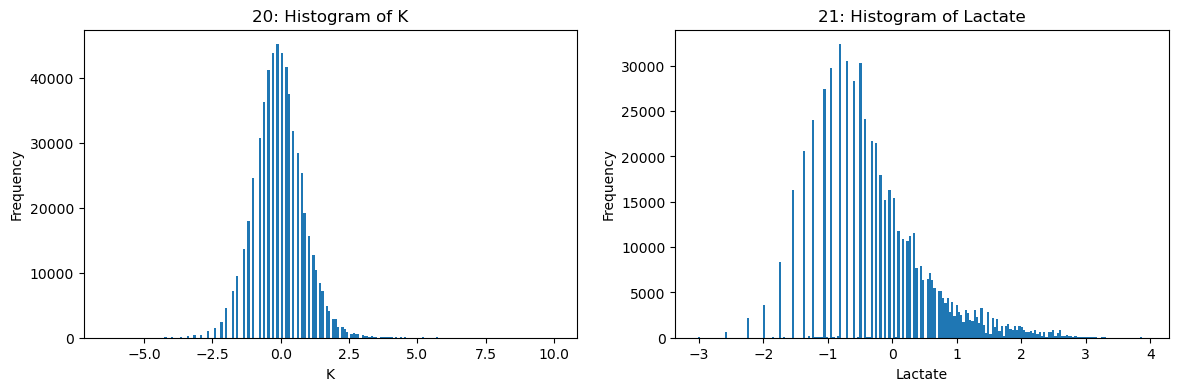

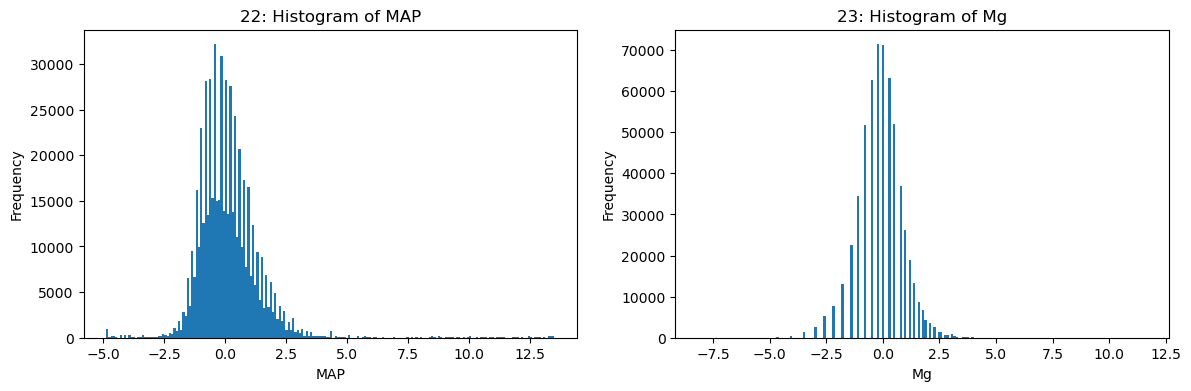

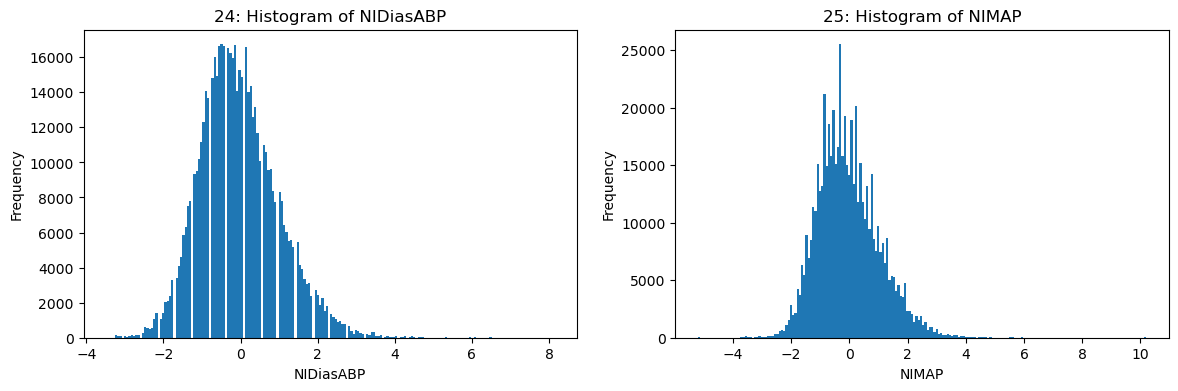

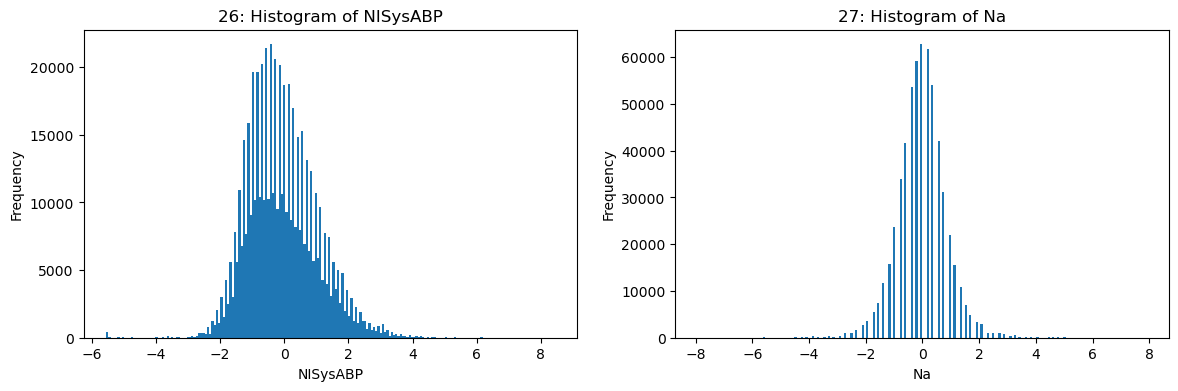

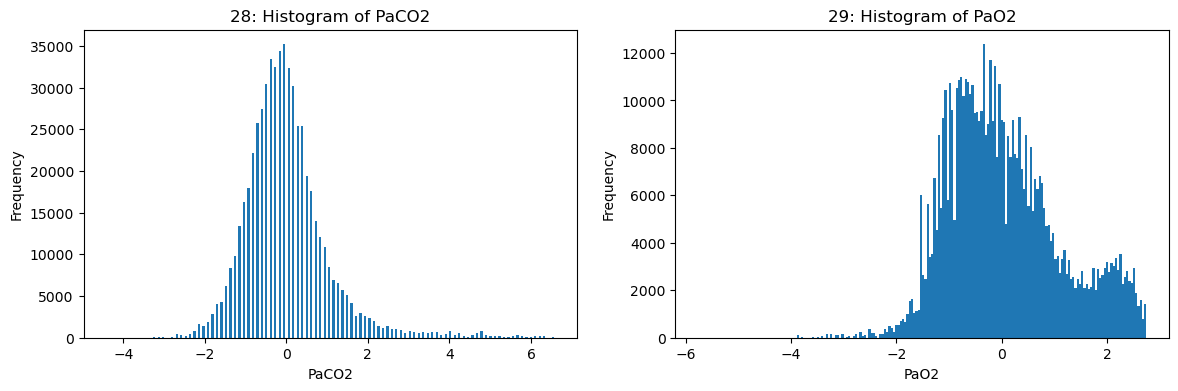

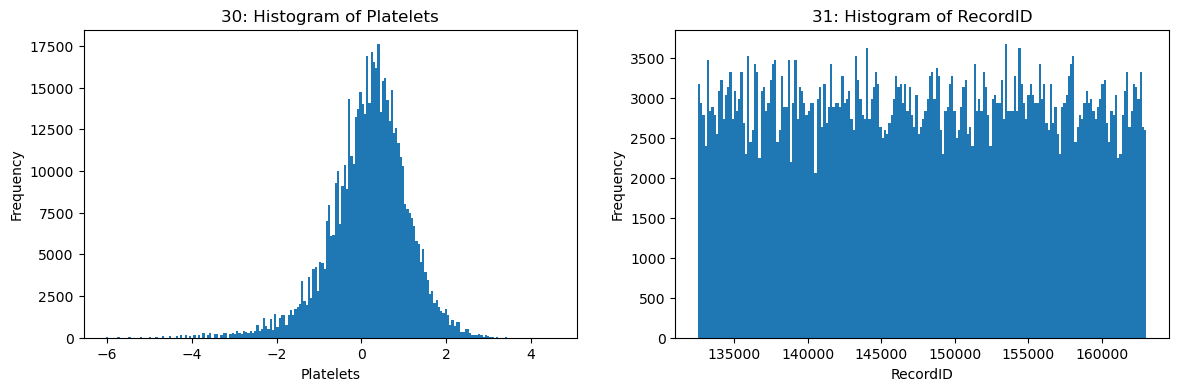

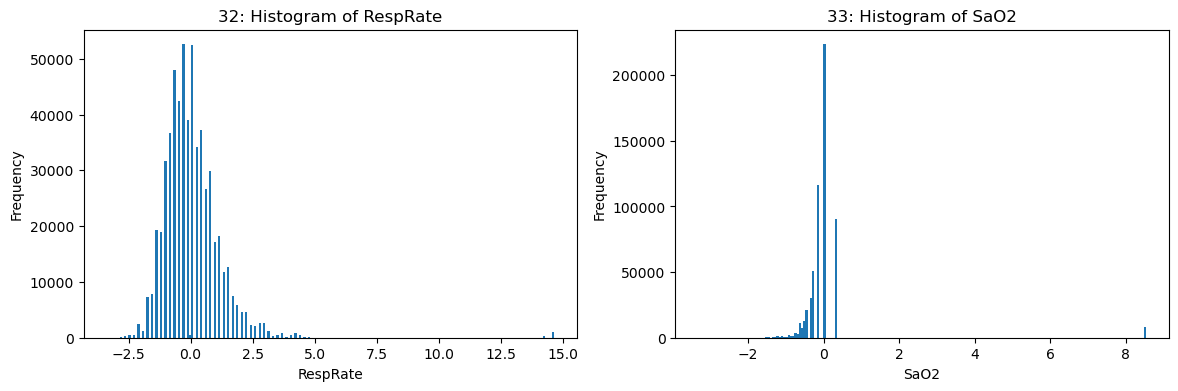

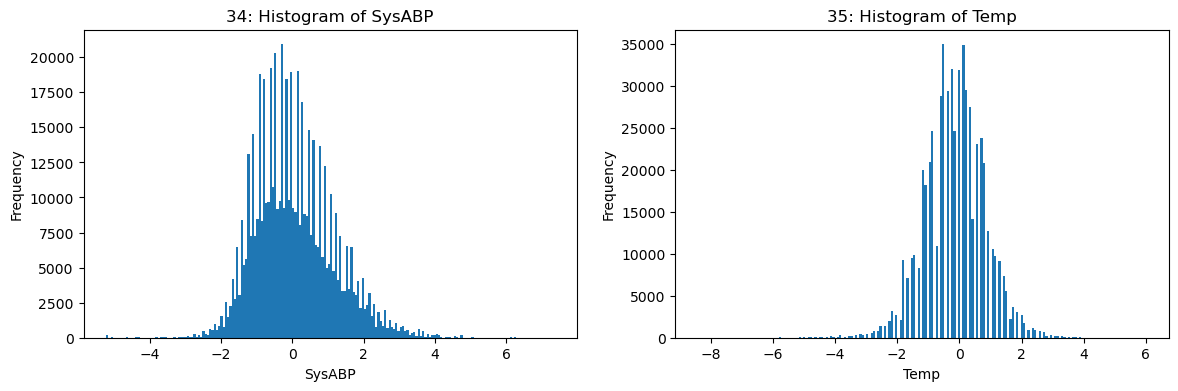

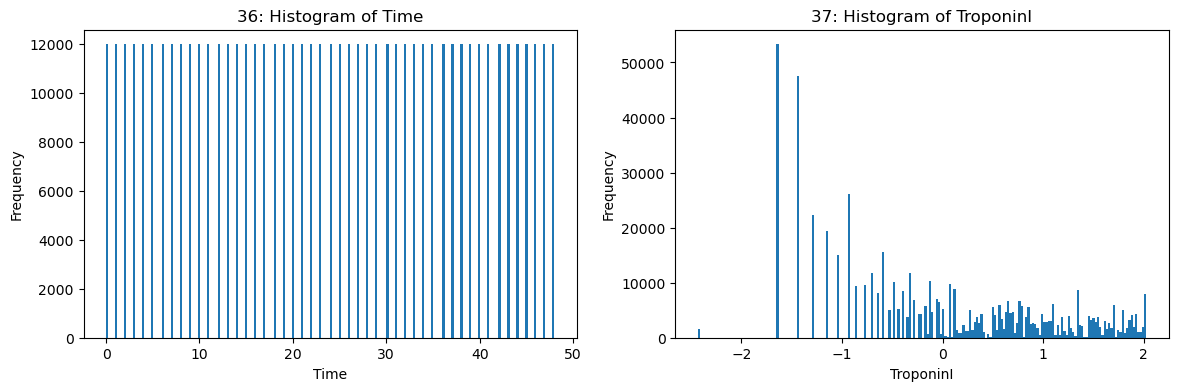

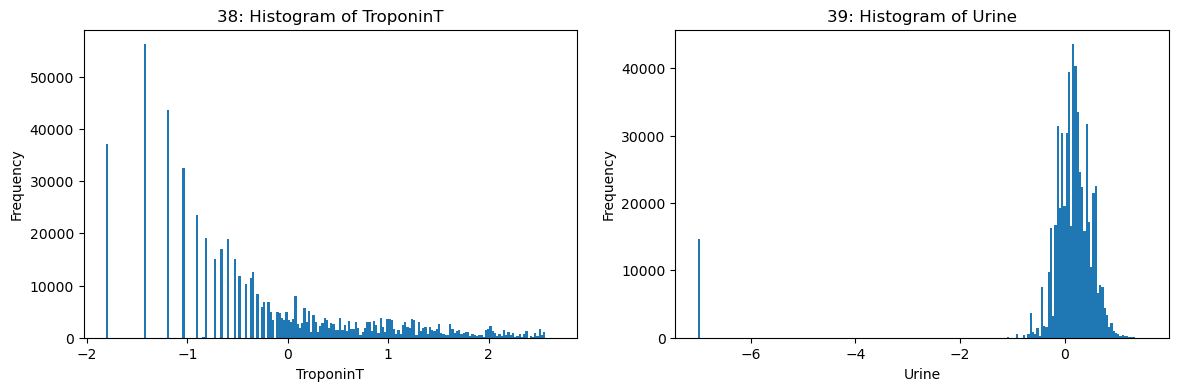

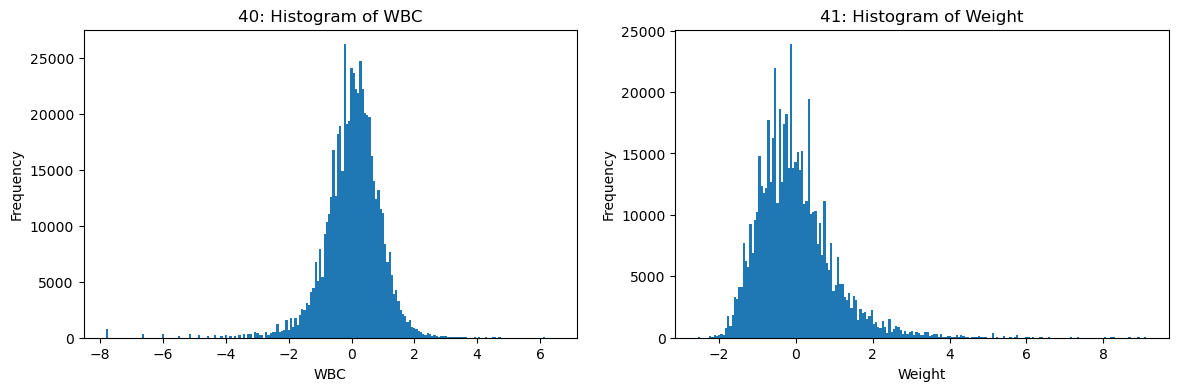

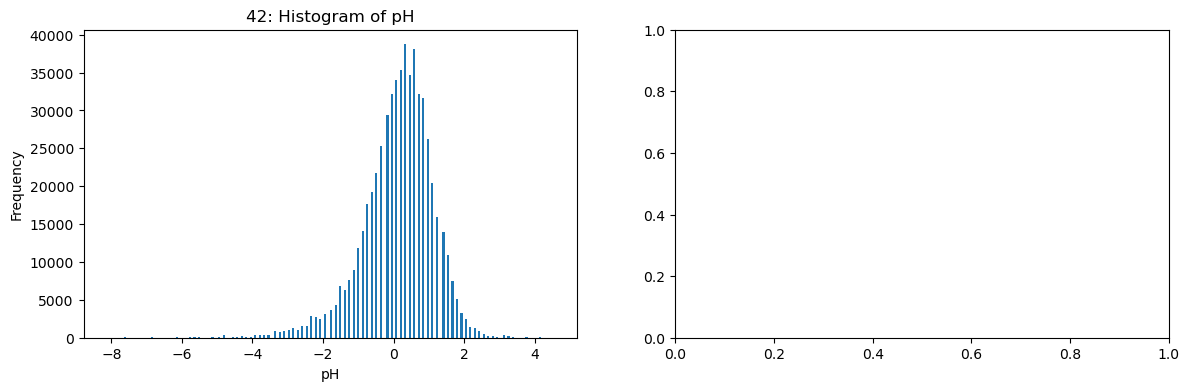

In [106]:
plot_histograms(bins_general, "scaled")

#  Classic Machine Learning Methods - Q2.1

Transform time series data to simple value per patient

In [107]:
def transform_time_series_to_vector(df, trafo_function="mean"):
    df = df.drop(columns=["ICUType"])

    static_vars = ['Age', 'Gender', 'Height']
    ts_vars = [col for col in df.columns if col not in static_vars + ['RecordID', 'Time']]

    if trafo_function == "mean":
        ts_df = df.groupby('RecordID')[ts_vars].mean()
    elif trafo_function == "max":
        ts_df = df.groupby('RecordID')[ts_vars].max()
    elif trafo_function == "last_measured":
        ts_df = df.sort_values("Time").groupby('RecordID')[ts_vars].last()
    else:
        raise ValueError("Invalid trafo_function")

    static_df = df.groupby('RecordID')[static_vars].first()
    return pd.concat([static_df, ts_df], axis=1)


Get Training , Validation or Test Data

In [115]:
def get_data(split="train"):
    letter_map = {"train": "a", "val": "b", "test": "c"}
    letter = letter_map[split]
    df = pd.read_parquet(f"data_{letter}_scaled.parquet")
    df = transform_time_series_to_vector(df, trafo_function="mean")
    y = df["In-hospital_death"]
    X = df.drop(columns=["In-hospital_death"])
    return X, y


In [127]:
X_train,y_train =get_data("train")
print(y.shape)
print(X.shape)
#X.head()

(4000,)
(4000, 39)


### Train Model

Training function

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

def train_and_evaluate_model(model, split="val"):

    X_train,y_train =get_data("train")

    model.fit(X_train, y_train)

    X_evaluate,y_evaluate =get_data(split)

    y_pred = model.predict_proba(X_evaluate)[:, 1]

    auroc = roc_auc_score(y_evaluate, y_pred)
    auprc = average_precision_score(y_evaluate, y_pred)

    print("AUROC:", auroc)
    print("AUPRC:", auprc)


###  Test models

In [128]:
from sklearn.linear_model import LogisticRegression

model_log_reg = LogisticRegression(max_iter=1000)
train_and_evaluate_model(model_log_reg, split="test")

AUROC: 0.809153182915994
AUPRC: 0.4394604706371753


In [129]:
from sklearn.ensemble import RandomForestClassifier

model_rand_forest = RandomForestClassifier(n_estimators=100, random_state=0)
train_and_evaluate_model(model_rand_forest, split="test")


AUROC: 0.8050513696487344
AUPRC: 0.43799286782678326


In [130]:
from sklearn.svm import SVC

model_svm = SVC(probability=True)
train_and_evaluate_model(model_svm, split="test")


AUROC: 0.7680189210496676
AUPRC: 0.3917599205717994


In [131]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=5)
train_and_evaluate_model(model_knn, split="test")


AUROC: 0.6610887111912003
AUPRC: 0.24354811767704038


In [132]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier()
train_and_evaluate_model(model_gb, split="test")


AUROC: 0.8121089712304941
AUPRC: 0.43910958541906464


In [133]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()
train_and_evaluate_model(model_nb, split="test")


AUROC: 0.7445948617837344
AUPRC: 0.3158511164446923


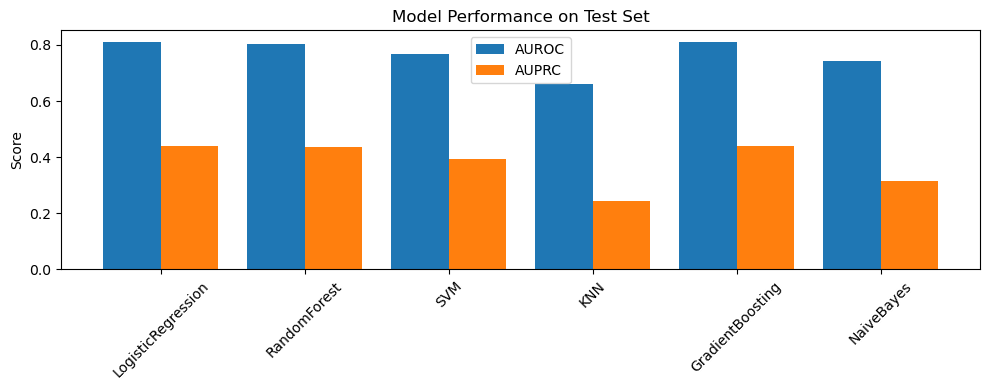

In [134]:
import matplotlib.pyplot as plt

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=0),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(),
    "NaiveBayes": GaussianNB()
}

results = {"Model": [], "AUROC": [], "AUPRC": []}

for name, model in models.items():
    X_train, y_train = get_data("train")
    X_test, y_test = get_data("test")

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    auroc = roc_auc_score(y_test, y_pred)
    auprc = average_precision_score(y_test, y_pred)

    results["Model"].append(name)
    results["AUROC"].append(auroc)
    results["AUPRC"].append(auprc)

# Plotting
x = range(len(results["Model"]))
plt.figure(figsize=(10, 4))

plt.bar(x, results["AUROC"], width=0.4, label="AUROC", align='center')
plt.bar([i + 0.4 for i in x], results["AUPRC"], width=0.4, label="AUPRC", align='center')
plt.xticks([i + 0.2 for i in x], results["Model"], rotation=45)
plt.ylabel("Score")
plt.title("Model Performance on Test Set")
plt.legend()
plt.tight_layout()
plt.show()


## Recurrent Neural Networks - Q2-2

this is random chatgpt code just to have a look, likely best do everything again

In [141]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, average_precision_score

# Adjust this based on your time series structure
TIME_COLUMN = "Time"
ID_COLUMN = "RecordID"

class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len=48):
        self.seq_len = seq_len
        self.samples = []
        self.labels = []
        for rid, group in df.groupby(ID_COLUMN):
            group = group.sort_values(TIME_COLUMN)
            X = group.drop(columns=["In-hospital_death", ID_COLUMN, TIME_COLUMN]).to_numpy()
            y = group["In-hospital_death"].iloc[0]
            # pad or truncate to fixed length
            if len(X) < seq_len:
                pad = np.zeros((seq_len - len(X), X.shape[1]))
                X = np.vstack([pad, X])
            else:
                X = X[-seq_len:]
            self.samples.append(X)
            self.labels.append(y)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out.squeeze(1)

def get_data(split="train"):
    letter_map = {"train": "a", "val": "b", "test": "c"}
    letter = letter_map[split]
    return pd.read_parquet(f"data_{letter}_scaled.parquet")

def train_and_evaluate_lstm(model, split="val", batch_size=64, epochs=10, lr=1e-3):
    train_df = get_data("train")
    val_df = get_data(split)

    train_ds = TimeSeriesDataset(train_df)
    val_ds = TimeSeriesDataset(val_df)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            out = model(x_batch)
            loss = loss_fn(out, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            logits = model(x_batch)
            probs = torch.sigmoid(logits).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(probs)

    auroc = roc_auc_score(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred)

    print("AUROC:", auroc)
    print("AUPRC:", auprc)

# Usage
input_size = get_data("train").drop(columns=["In-hospital_death", "RecordID", "Time"]).shape[1]
model = LSTMClassifier(input_size=input_size)
train_and_evaluate_lstm(model, split="test")


AUROC: 0.7997322020748082
AUPRC: 0.4549753646368854
